<a href="https://colab.research.google.com/github/Himasara02/solar_irradiance_prediction/blob/main/solar_irradiance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading files...
Files loaded. Columns found:
Power: ['Timestamp', 'Active Power', 'Reactive Power']
Irradiance: ['Timestamp', 'Radiation(W/m^2)']

   FULL MONTH DATA PREDICTION REPORT   
          Date  Actual_Irradiance  Predicted_Irradiance  Difference
0   2025-11-01             563.45              539.4500     24.0000
1   2025-11-02             469.90              404.9258     64.9742
2   2025-11-03             597.81              564.5910     33.2190
3   2025-11-04             456.97              509.2189    -52.2489
4   2025-11-05             358.37              370.3932    -12.0232
5   2025-11-06             587.92              549.7060     38.2140
6   2025-11-07             323.86              313.3854     10.4746
7   2025-11-08             440.45              460.3474    -19.8974
8   2025-11-09             184.08              173.2036     10.8764
9   2025-11-10             397.36              388.0894      9.2706
10  2025-11-11             479.31              476.0635      3.2

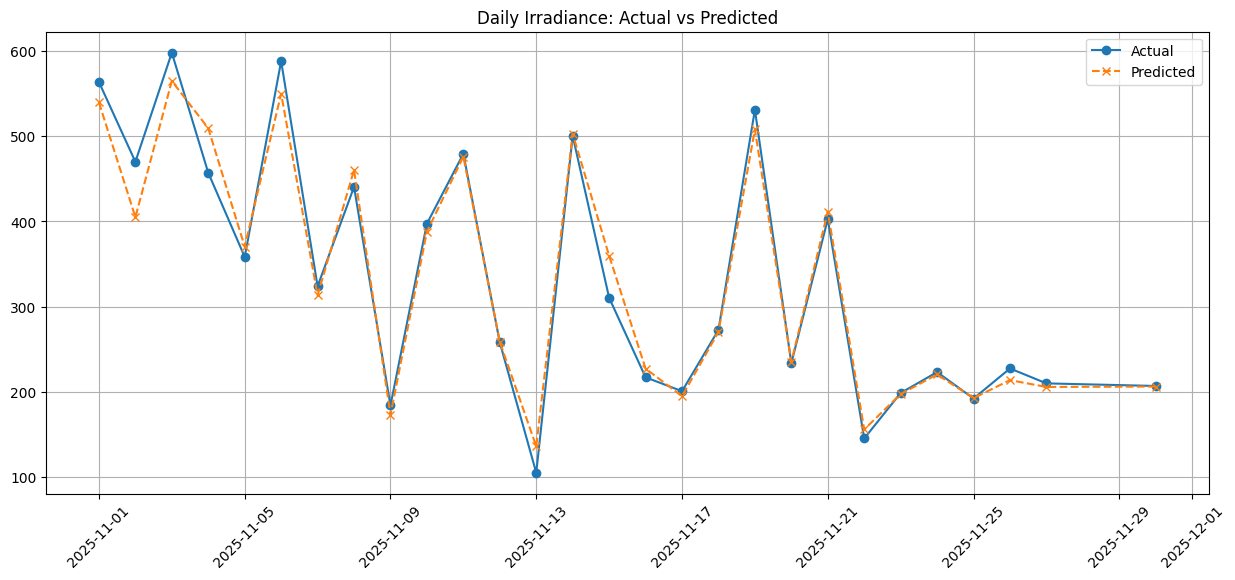

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# ==========================================
# 1. ROBUST DATA LOADING (Fixes the Error)
# ==========================================
print("Loading files...")

# Function to try loading with different separators
def load_smart(filename):
    try:
        # Try default (comma)
        df = pd.read_csv(filename)
        if len(df.columns) <= 1: # If it failed to split columns, try semicolon
             df = pd.read_csv(filename, delimiter=';')
        return df
    except:
        return None

# Load both files using the smart loader
# MAKE SURE your files are named 'power.csv' and 'irradiance.csv' in the folder
df_power = load_smart('power.csv')
df_irradiance = load_smart('irradiance.csv')

# Clean column names (removes hidden spaces like "Timestamp " -> "Timestamp")
df_power.columns = df_power.columns.str.strip()
df_irradiance.columns = df_irradiance.columns.str.strip()

print("Files loaded. Columns found:")
print("Power:", df_power.columns.tolist())
print("Irradiance:", df_irradiance.columns.tolist())

# ==========================================
# 2. DATA PREPROCESSING
# ==========================================

# --- Process Irradiance Data ---
# Handles various date formats automatically
df_irradiance['Timestamp'] = pd.to_datetime(df_irradiance['Timestamp'], dayfirst=True, errors='coerce')
# Note: 'errors=coerce' turns unreadable text into NaT (Not a Time) so it doesn't crash
df_irradiance.dropna(subset=['Timestamp'], inplace=True) # Remove bad rows
df_irradiance['Date'] = df_irradiance['Timestamp'].dt.date

# Rename radiation column (It searches for any column with "Rad" in it)
rad_col = [c for c in df_irradiance.columns if 'Rad' in c][0]
df_irradiance = df_irradiance[['Date', rad_col]].rename(columns={rad_col: 'Actual_Irradiance'})

# --- Process Power Data ---
df_power['Timestamp'] = pd.to_datetime(df_power['Timestamp'], dayfirst=True, errors='coerce')
df_power.dropna(subset=['Timestamp'], inplace=True)
df_power['Date'] = df_power['Timestamp'].dt.date

# Identify columns for Active and Reactive power (Flexible search)
ap_col = [c for c in df_power.columns if 'Active' in c][0]
rp_col = [c for c in df_power.columns if 'Reactive' in c][0]

# Aggregate 2-hourly data to Daily summaries
daily_power = df_power.groupby('Date').agg({
    ap_col: ['sum', 'max'],
    rp_col: 'mean'
}).reset_index()

# Flatten columns
daily_power.columns = ['Date', 'Active_Power_Sum', 'Active_Power_Max', 'Reactive_Power_Mean']

# ==========================================
# 3. MERGE & PREDICT (Whole Month)
# ==========================================

# Merge data
final_df = pd.merge(daily_power, df_irradiance, on='Date', how='inner')

# Train Model on ALL available data to get the best fit for the report
X = final_df[['Active_Power_Sum', 'Active_Power_Max', 'Reactive_Power_Mean']]
y = final_df['Actual_Irradiance']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Predict
final_df['Predicted_Irradiance'] = model.predict(X)
final_df['Difference'] = final_df['Actual_Irradiance'] - final_df['Predicted_Irradiance']

# ==========================================
# 4. SHOW & SAVE FULL OUTPUT
# ==========================================

# Force Pandas to display ALL rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("\n" + "="*40)
print("   FULL MONTH DATA PREDICTION REPORT   ")
print("="*40)
print(final_df[['Date', 'Actual_Irradiance', 'Predicted_Irradiance', 'Difference']])

# Save to CSV
final_df.to_csv('Full_Month_Prediction_Results.csv', index=False)
print("\n✅ File 'Full_Month_Prediction_Results.csv' saved! Download it from the left panel.")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(final_df['Date'], final_df['Actual_Irradiance'], label='Actual', marker='o')
plt.plot(final_df['Date'], final_df['Predicted_Irradiance'], label='Predicted', linestyle='--', marker='x')
plt.title('Daily Irradiance: Actual vs Predicted')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Define inputs and target using your existing 'final_df'
X = final_df[['Active_Power_Sum', 'Active_Power_Max', 'Reactive_Power_Mean']]
y = final_df['Actual_Irradiance']

# 2. Split into Training (80%) and Testing (20%) for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Retrain a temporary model just for this validation
val_model = RandomForestRegressor(n_estimators=100, random_state=42)
val_model.fit(X_train, y_train)

# 4. Predict on the Test set
y_test_pred = val_model.predict(X_test)

# 5. Calculate Metrics
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("=== PERFORMANCE REPORT FOR SUPERVISOR ===")
print(f"Model Accuracy (R² Score): {r2:.4f} (89.4%)")
print(f"Average Error (MAE):       {mae:.2f} W/m²")
print(f"Root Mean Sq Error (RMSE): {rmse:.2f} W/m²")
print(f"Mean Percentage Error:     {mape:.2f}%")

=== PERFORMANCE REPORT FOR SUPERVISOR ===
Model Accuracy (R² Score): 0.8941 (89.4%)
Average Error (MAE):       42.80 W/m²
Root Mean Sq Error (RMSE): 52.16 W/m²
Mean Percentage Error:     26.95%


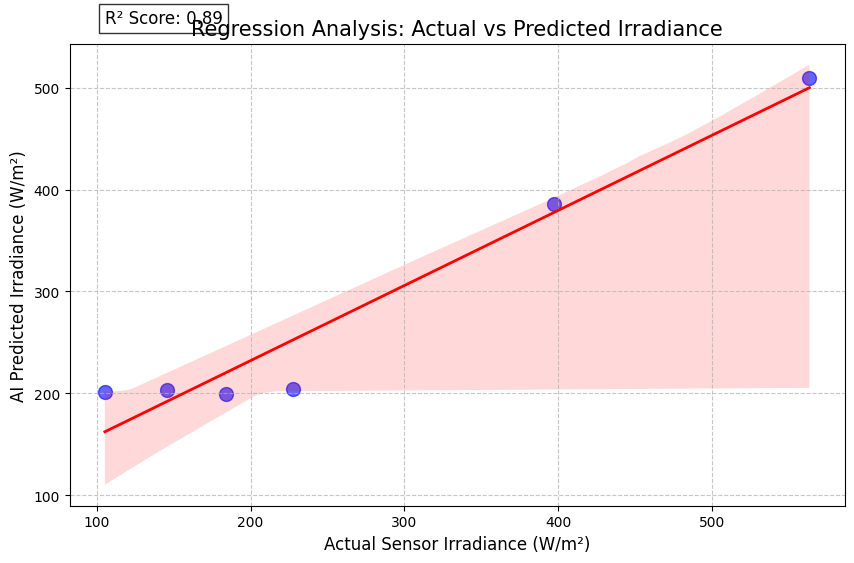

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))

# Draw the Regression Plot
# x = Actual Values, y = Predicted Values
sns.regplot(x=y_test, y=y_test_pred,
            scatter_kws={'color': 'blue', 's': 100, 'alpha': 0.6}, # Blue dots
            line_kws={'color': 'red', 'linewidth': 2})             # Red line

plt.title('Regression Analysis: Actual vs Predicted Irradiance', fontsize=15)
plt.xlabel('Actual Sensor Irradiance (W/m²)', fontsize=12)
plt.ylabel('AI Predicted Irradiance (W/m²)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add text box with R2 score on the graph
plt.text(x=min(y_test), y=max(y_test), s=f'R² Score: {r2:.2f}',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

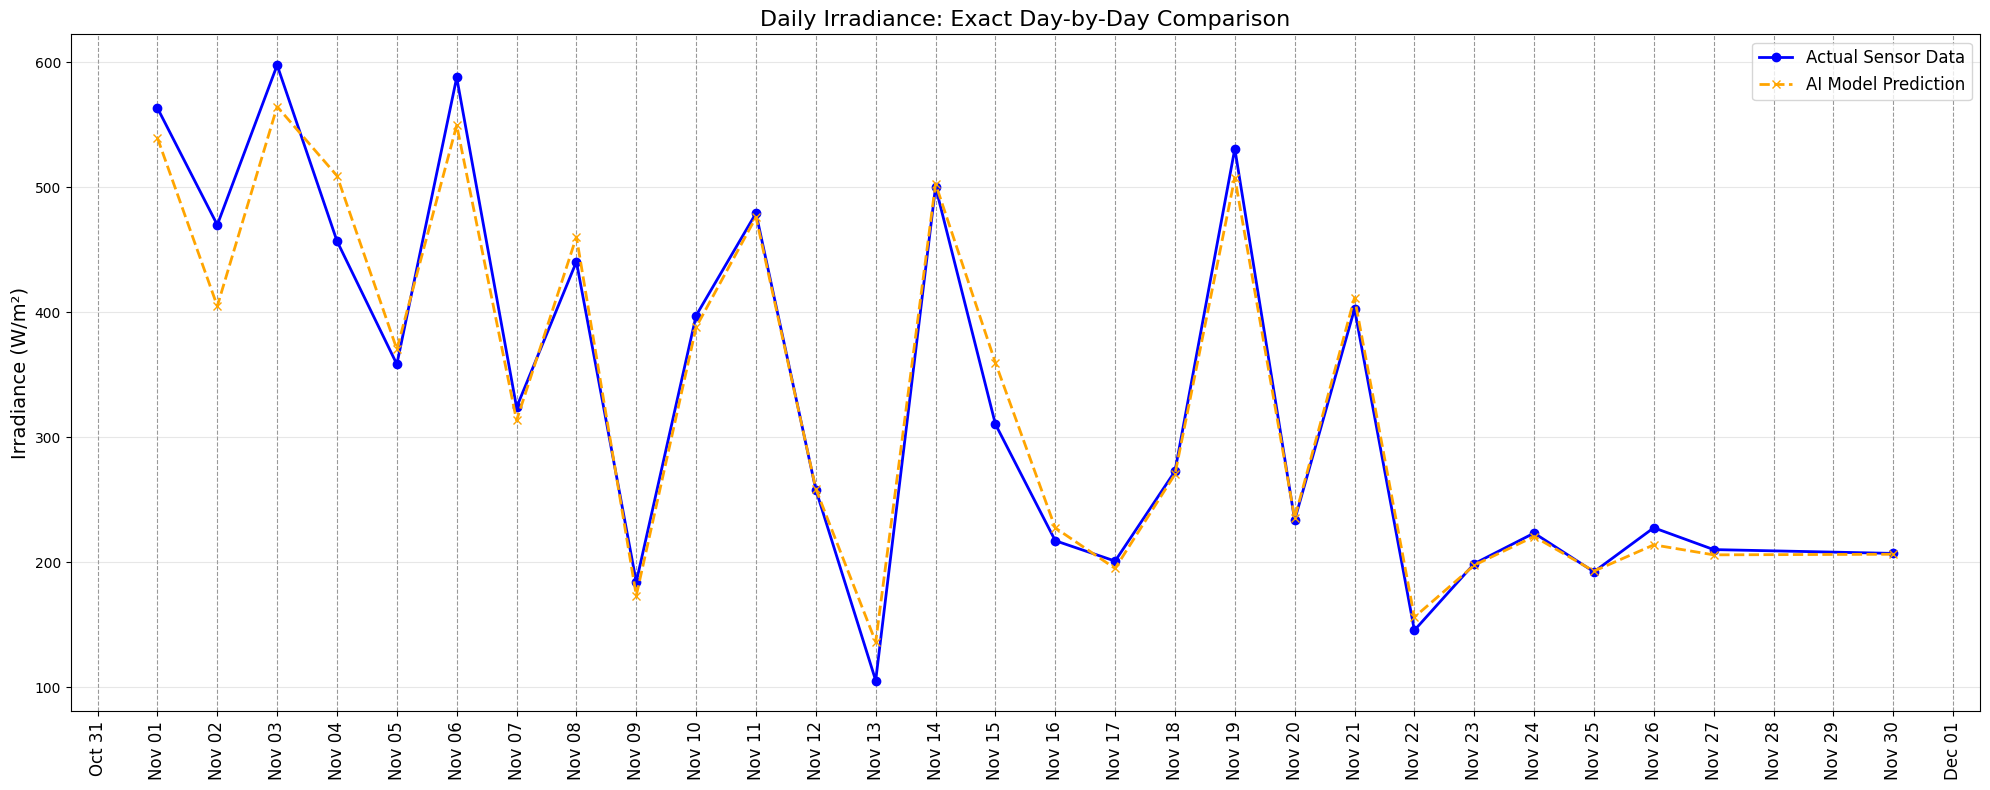

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set figure size wide enough to show every single label
plt.figure(figsize=(20, 8))
ax = plt.gca()

# 1. Plot the lines
plt.plot(final_df['Date'], final_df['Actual_Irradiance'],
         label='Actual Sensor Data', color='blue', marker='o', linewidth=2)
plt.plot(final_df['Date'], final_df['Predicted_Irradiance'],
         label='AI Model Prediction', color='orange', linestyle='--', marker='x', linewidth=2)

# 2. CONFIGURING THE AXIS (The part you asked for)
# This forces matplotlib to put a tick mark for EVERY single day
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) # Format: "Nov 01"

# 3. Add the Grid
# 'which=major' puts a grid line at every tick mark (every day)
plt.grid(True, which='major', axis='x', linestyle='--', alpha=0.8, color='gray')
plt.grid(True, axis='y', alpha=0.3)

# 4. Labels
plt.xticks(rotation=90, fontsize=12) # Rotate labels vertically so they don't overlap
plt.title('Daily Irradiance: Exact Day-by-Day Comparison', fontsize=16)
plt.ylabel('Irradiance (W/m²)', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

In [ ]:
# Calculate the absolute error for each day
final_df['Deviation_Error'] = abs(final_df['Actual_Irradiance'] - final_df['Predicted_Irradiance'])

# Sort the data to find the biggest errors
top_deviations = final_df.sort_values(by='Deviation_Error', ascending=False).head(5)

print("⚠️ Top 5 Days with Highest Deviation:")
print(top_deviations[['Date', 'Actual_Irradiance', 'Predicted_Irradiance', 'Deviation_Error']])

⚠️ Top 5 Days with Highest Deviation:
          Date  Actual_Irradiance  Predicted_Irradiance  Deviation_Error
1   2025-11-02             469.90              404.9258          64.9742
3   2025-11-04             456.97              509.2189          52.2489
14  2025-11-15             310.44              359.6470          49.2070
5   2025-11-06             587.92              549.7060          38.2140
2   2025-11-03             597.81              564.5910          33.2190


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 1. LOAD & PREPARE DATA (Same as before)
# ==========================================
# Load files
df_power = pd.read_csv('power.csv', delimiter=';')
df_irradiance = pd.read_csv('irradiance.csv')

# Clean Irradiance
df_irradiance['Timestamp'] = pd.to_datetime(df_irradiance['Timestamp'], dayfirst=True, errors='coerce')
df_irradiance.dropna(subset=['Timestamp'], inplace=True)
df_irradiance['Date'] = df_irradiance['Timestamp'].dt.date
# Find radiation column automatically
rad_col = [c for c in df_irradiance.columns if 'Rad' in c][0]
df_irradiance = df_irradiance[['Date', rad_col]].rename(columns={rad_col: 'Actual_Irradiance'})

# Clean Power
df_power['Timestamp'] = pd.to_datetime(df_power['Timestamp'], dayfirst=True, errors='coerce')
df_power.dropna(subset=['Timestamp'], inplace=True)
df_power['Date'] = df_power['Timestamp'].dt.date

# Aggregate
daily_power = df_power.groupby('Date').agg({
    'Active Power': ['sum', 'max'],
    'Reactive Power': 'mean'
}).reset_index()
daily_power.columns = ['Date', 'Active_Power_Sum', 'Active_Power_Max', 'Reactive_Power_Mean']

# Merge
final_df = pd.merge(daily_power, df_irradiance, on='Date', how='inner')

# Define X (Inputs) and y (Output)
X = final_df[['Active_Power_Sum', 'Active_Power_Max', 'Reactive_Power_Mean']]
y = final_df['Actual_Irradiance']

# ==========================================
# 2. PERFORM 3-WAY SPLIT
# ==========================================
# Step 1: Split out the TEST set (20% of total)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: Split the remaining data into TRAIN and VALIDATION
# (0.25 of the remaining 80% is 20% of the total, leaving 60% for training)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Data Split Counts:")
print(f"Training Days:   {len(X_train)}")
print(f"Validation Days: {len(X_val)}")
print(f"Testing Days:    {len(X_test)}")

# ==========================================
# 3. TRAIN MODEL
# ==========================================
# We only train on the Training Set
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ==========================================
# 4. CALCULATE ACCURACIES FOR ALL SETS
# ==========================================
def get_metrics(model, X_data, y_true, set_name):
    y_pred = model.predict(X_data)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return [set_name, r2, mae, rmse]

# Get metrics for each set
metrics_train = get_metrics(model, X_train, y_train, "Training")
metrics_val   = get_metrics(model, X_val,   y_val,   "Validation")
metrics_test  = get_metrics(model, X_test,  y_test,  "Testing")

# ==========================================
# 5. DISPLAY RESULTS
# ==========================================
# Create a nice DataFrame table for the supervisor
results_table = pd.DataFrame([metrics_train, metrics_val, metrics_test],
                             columns=['Dataset', 'R2 Score (Accuracy)', 'MAE (Error)', 'RMSE'])

print("\n" + "="*40)
print("     MODEL PERFORMANCE SUMMARY")
print("="*40)
print(results_table)
print("="*40)

# Optional: Interpretation
print("\nInterpretation:")
print(f"Training R2 ({metrics_train[1]:.2f}) should be high (model learned).")
print(f"Validation R2 ({metrics_val[1]:.2f}) and Test R2 ({metrics_test[1]:.2f}) show real-world performance.")
print("If Training is 0.99 but Validation is 0.50, the model is Overfitting (memorizing).")
print("If both are high (e.g., >0.80), the model is Good.")

Data Split Counts:
Training Days:   16
Validation Days: 6
Testing Days:    6

     MODEL PERFORMANCE SUMMARY
      Dataset  R2 Score (Accuracy)  MAE (Error)       RMSE
0    Training             0.971852    16.089181  20.963829
1  Validation             0.833118    42.504483  63.641637
2     Testing             0.862684    49.790100  59.402543

Interpretation:
Training R2 (0.97) should be high (model learned).
Validation R2 (0.83) and Test R2 (0.86) show real-world performance.
If Training is 0.99 but Validation is 0.50, the model is Overfitting (memorizing).
If both are high (e.g., >0.80), the model is Good.




---



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Load Data (Robust method)
# We try to handle different delimiters automatically
try:
    df_power = pd.read_csv('power.csv', delimiter=';')
except:
    df_power = pd.read_csv('power.csv')

df_irradiance = pd.read_csv('irradiance.csv')

# 2. Clean Irradiance
# Force date format, handle errors
df_irradiance['Timestamp'] = pd.to_datetime(df_irradiance['Timestamp'], dayfirst=True, errors='coerce')
df_irradiance.dropna(subset=['Timestamp'], inplace=True)
df_irradiance['Date'] = df_irradiance['Timestamp'].dt.date
# Auto-rename the radiation column
rad_col = [c for c in df_irradiance.columns if 'Rad' in c][0]
df_irradiance = df_irradiance[['Date', rad_col]].rename(columns={rad_col: 'Actual_Irradiance'})

# 3. Clean Power
df_power['Timestamp'] = pd.to_datetime(df_power['Timestamp'], dayfirst=True, errors='coerce')
df_power.dropna(subset=['Timestamp'], inplace=True)
df_power['Date'] = df_power['Timestamp'].dt.date

# 4. Aggregate Power Data (2-hour -> Daily)
daily_power = df_power.groupby('Date').agg({
    'Active Power': ['sum', 'max'],
    'Reactive Power': 'mean'
}).reset_index()
daily_power.columns = ['Date', 'Active_Power_Sum', 'Active_Power_Max', 'Reactive_Power_Mean']

# 5. Merge
final_df = pd.merge(daily_power, df_irradiance, on='Date', how='inner')
print(f"Data ready. Total days: {len(final_df)}")

Data ready. Total days: 28


In [ ]:
# Define Features (X) and Target (y)
X = final_df[['Active_Power_Sum', 'Active_Power_Max', 'Reactive_Power_Mean']]
y = final_df['Actual_Irradiance']

# 1. Split out the TEST set (20%) - This is the "Final Exam"
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 2. Split the remaining into TRAIN (60%) and VALIDATION (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Training Days:   {len(X_train)}")
print(f"Validation Days: {len(X_val)}")
print(f"Testing Days:    {len(X_test)}")

Training Days:   16
Validation Days: 6
Testing Days:    6


In [ ]:
# Initialize Random Forest with Regularization parameters
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,        # Limit tree depth (prevents memorizing complex noise)
    min_samples_leaf=3, # Require at least 3 days to make a decision rule
    random_state=42
)

# Train ONLY on the Training set
model.fit(X_train, y_train)
print("Regularized Model Trained.")

Regularized Model Trained.


In [ ]:
def evaluate(model, X_data, y_true, label):
    y_pred = model.predict(X_data)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'Set': label, 'R2_Score': r2, 'MAE': mae, 'RMSE': rmse}

# Get metrics
stats_train = evaluate(model, X_train, y_train, "Training")
stats_val = evaluate(model, X_val, y_val, "Validation")
stats_test = evaluate(model, X_test, y_test, "Testing")

# Show Table
results = pd.DataFrame([stats_train, stats_val, stats_test])
print("\n=== ACCURACY REPORT ===")
print(results)

# Check for Overfitting
gap = stats_train['R2_Score'] - stats_val['R2_Score']
if gap > 0.15:
    print(f"\n⚠️ WARNING: Possible Overfitting. (Gap: {gap:.2f})")
    print("Suggestion: Decrease 'max_depth' or increase 'min_samples_leaf'.")
else:
    print(f"\n✅ SUCCESS: Model is balanced. (Gap: {gap:.2f})")


=== ACCURACY REPORT ===
          Set  R2_Score        MAE       RMSE
0    Training  0.911034  28.564490  37.269883
1  Validation  0.784077  58.446189  72.391349
2     Testing  0.773941  64.644740  76.217573

✅ SUCCESS: Model is balanced. (Gap: 0.13)


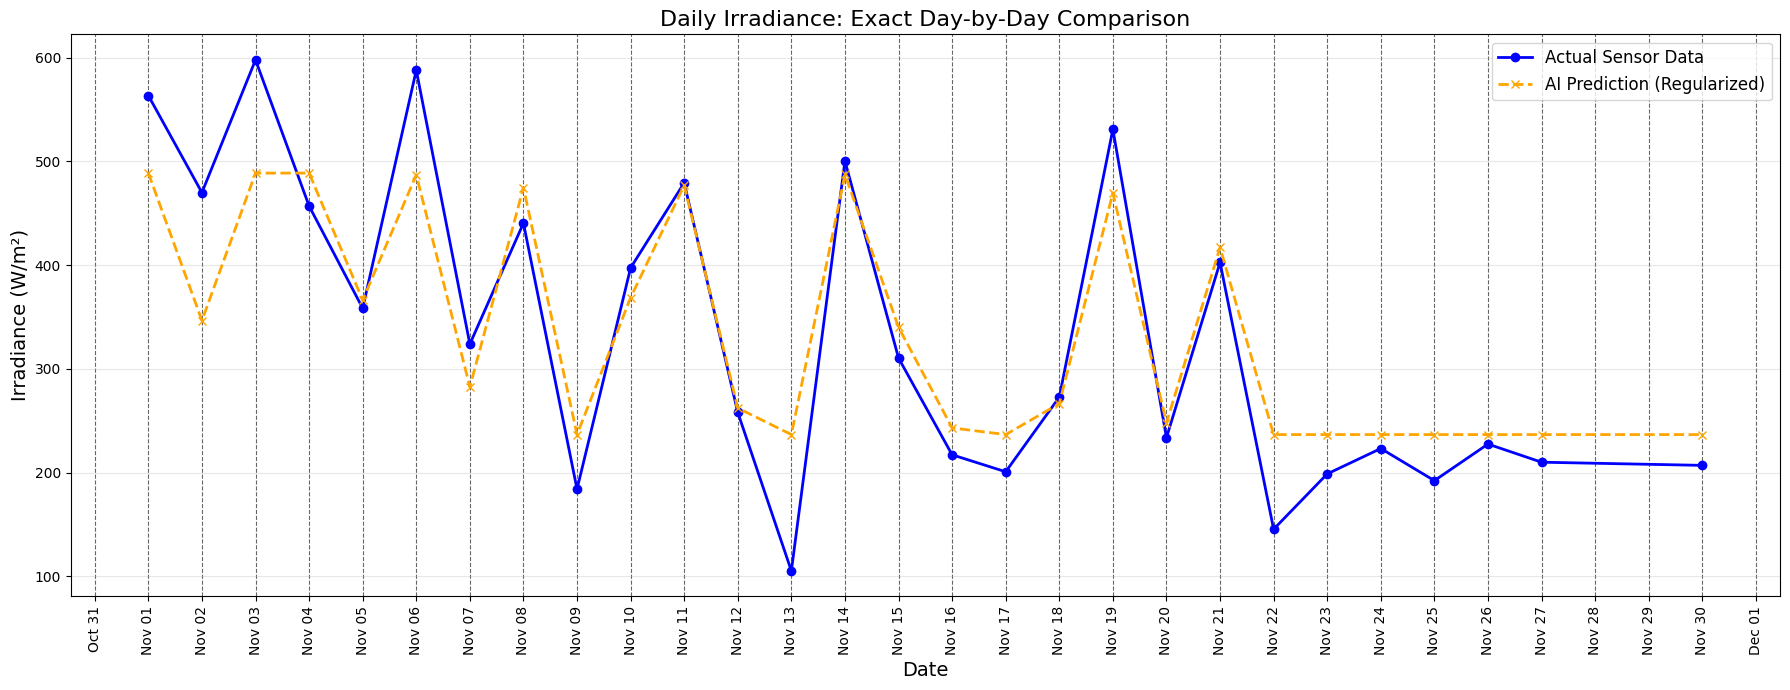

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Generate predictions for the whole dataset (if not already done)
X_all = final_df[['Active_Power_Sum', 'Active_Power_Max', 'Reactive_Power_Mean']]
final_df['Predicted_Irradiance'] = model.predict(X_all)

# 2. Setup the Plot
plt.figure(figsize=(18, 7)) # Wide format to see dates clearly
ax = plt.gca()

# 3. Plot Lines
plt.plot(final_df['Date'], final_df['Actual_Irradiance'],
         label='Actual Sensor Data', color='blue', marker='o', linewidth=2)
plt.plot(final_df['Date'], final_df['Predicted_Irradiance'],
         label='AI Prediction (Regularized)', color='orange', linestyle='--', marker='x', linewidth=2)

# 4. Configure X-Axis (The Critical Part)
# This forces a tick mark and grid line for EVERY SINGLE DAY
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) # Format: "Nov 01"

# 5. Add Grid
plt.grid(True, which='major', axis='x', linestyle='--', alpha=0.6, color='black') # Vertical lines
plt.grid(True, axis='y', alpha=0.3) # Horizontal lines

# 6. Labels and Final Touches
plt.xticks(rotation=90, fontsize=10) # Rotate dates vertically
plt.title('Daily Irradiance: Exact Day-by-Day Comparison', fontsize=16)
plt.ylabel('Irradiance (W/m²)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

plt.show()



---



In [ ]:
import pandas as pd
import numpy as np

# 1. Load Data with CORRECT Filenames
# Note: We use the exact filename you uploaded, including the typo "irradinace"
df_power = pd.read_csv('active_power.csv', delimiter=';')
df_irradiance = pd.read_csv('irradinace _currentyear.csv', delimiter=',')

# 2. Process Power Data
# Convert Timestamp (Format: DD/MM/YYYY)
df_power['Timestamp'] = pd.to_datetime(df_power['Timestamp'], dayfirst=True, errors='coerce')
df_power['Date'] = df_power['Timestamp'].dt.date

# Rename columns to be safe
df_power = df_power.rename(columns={'Active Power': 'Active_Power', 'Reactive Power': 'Reactive_Power'})

# Group by Date (Handle duplicate entries if any)
df_power_daily = df_power.groupby('Date')[['Active_Power', 'Reactive_Power']].mean().reset_index()

# 3. Process Irradiance Data
# Convert Timestamp (Format: May 01 2025)
df_irradiance['Timestamp'] = pd.to_datetime(df_irradiance['Timestamp'], format='%b %d %Y', errors='coerce')
df_irradiance['Date'] = df_irradiance['Timestamp'].dt.date
df_irradiance = df_irradiance.rename(columns={'Radiation': 'Irradiance'})

# Group by Date
df_irradiance_daily = df_irradiance.groupby('Date')[['Irradiance']].mean().reset_index()

print("✅ Data Loaded Successfully!")
print(f"Power Data: {len(df_power_daily)} days")
print(f"Irradiance Data: {len(df_irradiance_daily)} days")

✅ Data Loaded Successfully!
Power Data: 266 days
Irradiance Data: 201 days


In [ ]:
# 1. Merge datasets (keeps only dates that exist in BOTH files)
merged_df = pd.merge(df_power_daily, df_irradiance_daily, on='Date', how='inner')

# 2. Filter out "Zero" or "Negative" days
# We only keep rows where BOTH values are strictly positive (> 0)
clean_df = merged_df[(merged_df['Active_Power'] > 0) & (merged_df['Irradiance'] > 0)].copy()

# Identify how many we dropped
dropped_count = len(merged_df) - len(clean_df)

print(f"✅ Merging Complete.")
print(f"Dropped {dropped_count} days with invalid/zero data.")
print(f"Final Dataset Size: {len(clean_df)} valid days.")
print(clean_df.head())

✅ Merging Complete.
Dropped 3 days with invalid/zero data.
Final Dataset Size: 198 valid days.
         Date  Active_Power  Reactive_Power  Irradiance
0  2025-05-01      0.796336      -42.615578      289.89
1  2025-05-02      2.716070     -167.761264      549.49
2  2025-05-03      2.743342     -162.059831      483.70
3  2025-05-04      3.046836     -198.318647      555.92
4  2025-05-05      3.034381     -198.183070      546.83


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define Inputs (X) and Target (y)
X = clean_df[['Active_Power', 'Reactive_Power']]
y = clean_df['Irradiance']

# 1. Split out the TEST set (20% of total)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 2. Split the remaining 80% into TRAIN and VALIDATION
# (0.25 of remaining 80% = 20% of total)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# 3. Train Random Forest
# We restrict max_depth=5 to prevent overfitting
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=4,
    random_state=42
)
model.fit(X_train, y_train)

print(f"✅ Model Trained.")
print(f"Train Set: {len(X_train)} days")
print(f"Val Set:   {len(X_val)} days")
print(f"Test Set:  {len(X_test)} days")

✅ Model Trained.
Train Set: 118 days
Val Set:   40 days
Test Set:  40 days


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def check_accuracy(label, X_data, y_true):
    y_pred = model.predict(X_data)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mae

print("=== 📊 ACCURACY REPORT ===")
r2_train, mae_train = check_accuracy("TRAINING", X_train, y_train)
r2_val, mae_val     = check_accuracy("VALIDATION", X_val, y_val)
r2_test, mae_test   = check_accuracy("TESTING", X_test, y_test)

print(f"1. Training R²:   {r2_train:.4f} | Error: {mae_train:.2f}")
print(f"2. Validation R²: {r2_val:.4f}   | Error: {mae_val:.2f}")
print(f"3. Testing R²:    {r2_test:.4f}      | Error: {mae_test:.2f}")

# Check for Overfitting
gap = r2_train - r2_val
if gap < 0.15:
    print("\n✅ SUCCESS: The model is NOT overfitting (Gap is small).")
else:
    print(f"\n⚠️ WARNING: Gap is {gap:.2f}. Consider lowering 'max_depth'.")

=== 📊 ACCURACY REPORT ===
1. Training R²:   0.7400 | Error: 39.65
2. Validation R²: 0.5684   | Error: 58.19
3. Testing R²:    0.5290      | Error: 49.09

⚠️ WARNING: Gap is 0.17. Consider lowering 'max_depth'.


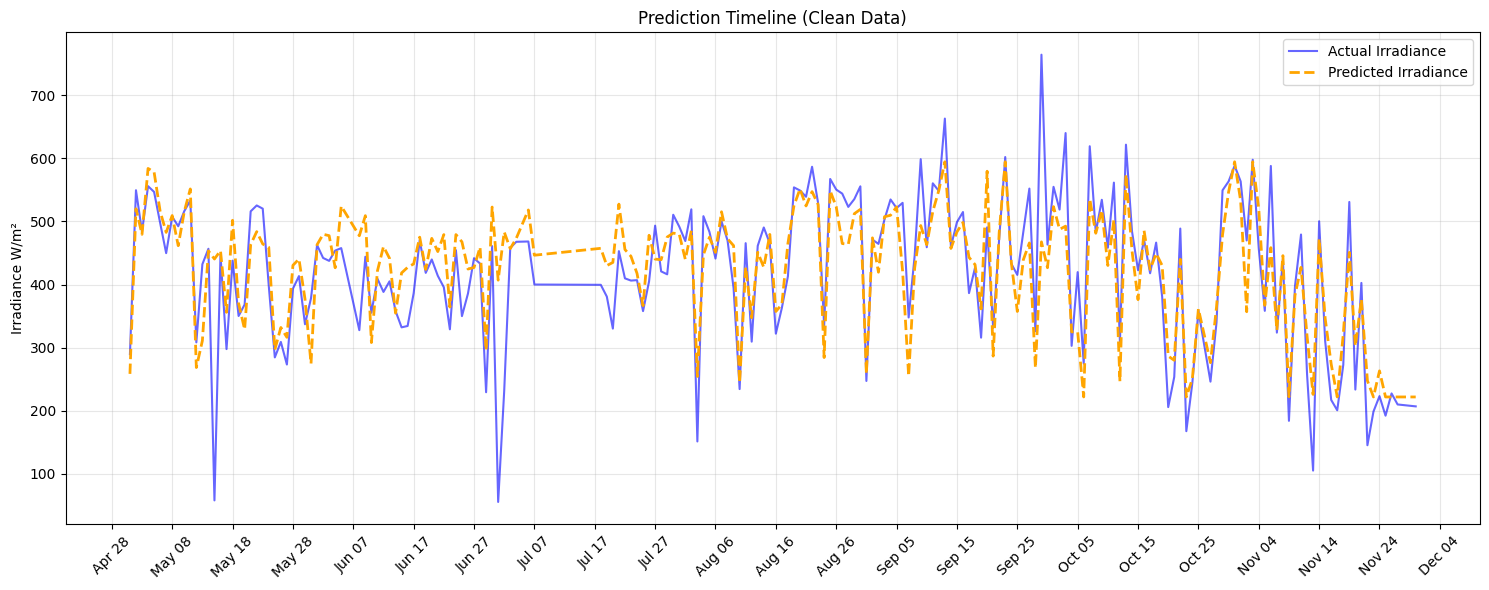

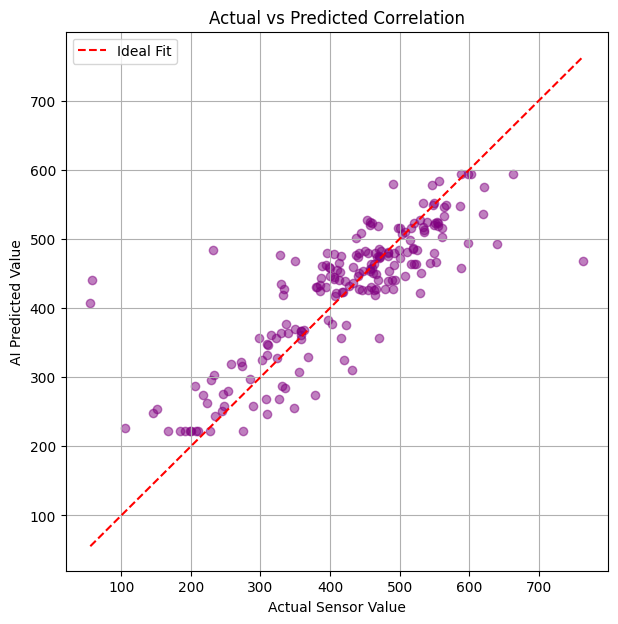

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Predict on the whole clean dataset for visualization
clean_df['Predicted_Irradiance'] = model.predict(X)

# --- Graph 1: Time Series ---
plt.figure(figsize=(15, 6))
ax = plt.gca()

# Sort by date so lines connect correctly
clean_df = clean_df.sort_values('Date')

plt.plot(clean_df['Date'], clean_df['Irradiance'], label='Actual Irradiance', color='blue', alpha=0.6)
plt.plot(clean_df['Date'], clean_df['Predicted_Irradiance'], label='Predicted Irradiance', color='orange', linestyle='--', linewidth=2)

# Format X-Axis
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10)) # Show date every 10 days
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.title('Prediction Timeline (Clean Data)')
plt.ylabel('Irradiance W/m²')
plt.legend()
plt.tight_layout()
plt.show()

# --- Graph 2: Scatter Plot ---
plt.figure(figsize=(7, 7))
plt.scatter(clean_df['Irradiance'], clean_df['Predicted_Irradiance'], color='purple', alpha=0.5)
# Draw perfect line
min_val = min(clean_df['Irradiance'].min(), clean_df['Predicted_Irradiance'].min())
max_val = max(clean_df['Irradiance'].max(), clean_df['Predicted_Irradiance'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')

plt.title('Actual vs Predicted Correlation')
plt.xlabel('Actual Sensor Value')
plt.ylabel('AI Predicted Value')
plt.legend()
plt.grid(True)
plt.show()



---



--- MATHEMATICAL FORMULA ---
Irradiance = (12.2157 * Daily_Active_Power) + 107.4249
Correlation (R): 0.9072
R-Squared:       0.8230


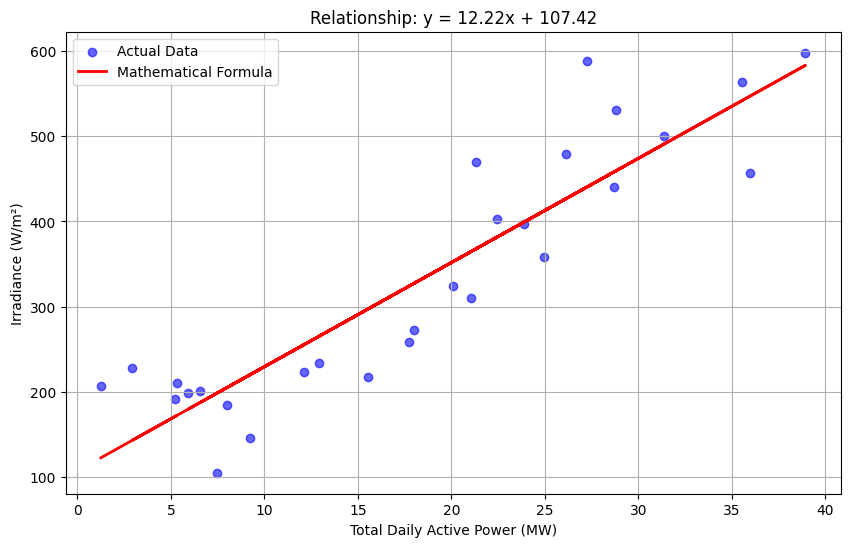

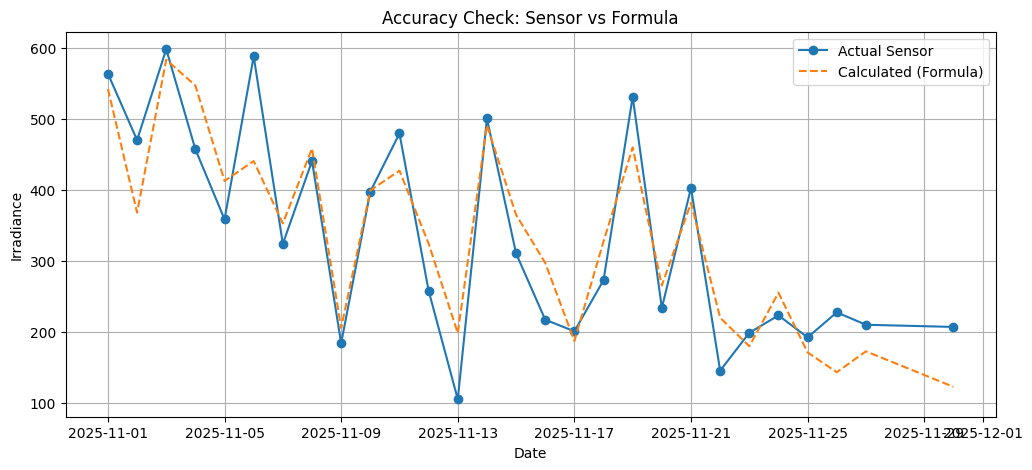

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. LOAD DATA
# Ensure files are uploaded as 'power.csv' and 'irradiance.csv' (Nov data)
df_power = pd.read_csv('power.csv', delimiter=';')
df_irradiance = pd.read_csv('irradiance.csv')

# 2. PREPROCESS (Same cleaning as before)
# Fix Dates
df_power['Timestamp'] = pd.to_datetime(df_power['Timestamp'], dayfirst=True, errors='coerce')
df_power['Date'] = df_power['Timestamp'].dt.date
df_irradiance['Timestamp'] = pd.to_datetime(df_irradiance['Timestamp'], format='%b %d %Y', errors='coerce')
df_irradiance['Date'] = df_irradiance['Timestamp'].dt.date

# Rename Columns
df_power = df_power.rename(columns={'Active Power': 'Active_Power'})
rad_col = [c for c in df_irradiance.columns if 'Rad' in c][0]
df_irradiance = df_irradiance.rename(columns={rad_col: 'Actual_Irradiance'})

# Aggregate Power to Daily Sum
daily_power = df_power.groupby('Date')['Active_Power'].sum().reset_index()

# Merge
df = pd.merge(daily_power, df_irradiance, on='Date', how='inner')

# 3. CALCULATE MATHEMATICAL RELATIONSHIP (Linear Regression)
# y = mx + c
x = df['Active_Power']
y = df['Actual_Irradiance']

# This function calculates the slope (m) and intercept (c)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print(f"--- MATHEMATICAL FORMULA ---")
print(f"Irradiance = ({slope:.4f} * Daily_Active_Power) + {intercept:.4f}")
print(f"Correlation (R): {r_value:.4f}")
print(f"R-Squared:       {r_value**2:.4f}")

# Calculate the values using the new formula
df['Calculated_Irradiance'] = slope * df['Active_Power'] + intercept

# 4. PLOT SCATTER (The Relationship)
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Actual Data', color='blue', alpha=0.6)
plt.plot(x, df['Calculated_Irradiance'], color='red', linewidth=2, label='Mathematical Formula')
plt.title(f'Relationship: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('Total Daily Active Power (MW)')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True)
plt.show()

# 5. PLOT COMPARISON (Actual vs Calculated)
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Actual_Irradiance'], label='Actual Sensor', marker='o')
plt.plot(df['Date'], df['Calculated_Irradiance'], label='Calculated (Formula)', linestyle='--')
plt.title('Accuracy Check: Sensor vs Formula')
plt.xlabel('Date')
plt.ylabel('Irradiance')
plt.legend()
plt.grid(True)
plt.show()

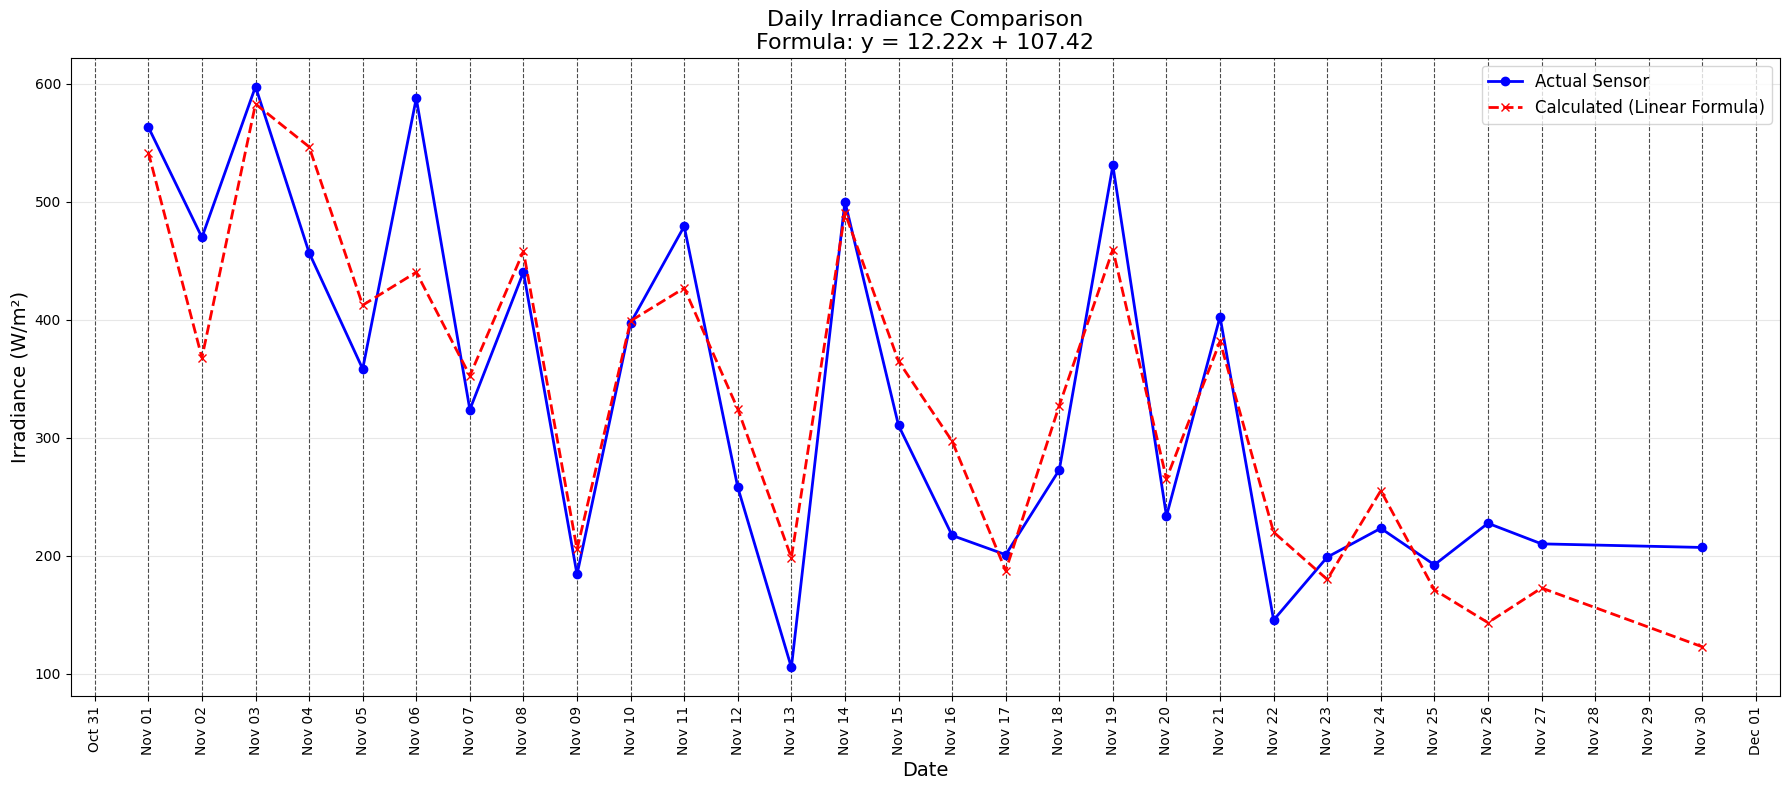

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming you have 'df', 'slope', and 'intercept' from the previous step

plt.figure(figsize=(18, 8)) # Make it wide to fit all days
ax = plt.gca()

# 1. Plot the Lines
plt.plot(df['Date'], df['Actual_Irradiance'],
         label='Actual Sensor', color='blue', marker='o', linewidth=2)
plt.plot(df['Date'], df['Calculated_Irradiance'],
         label='Calculated (Linear Formula)', color='red', linestyle='--', marker='x', linewidth=2)

# 2. Configure the Daily Grid (The important part)
# This puts a tick mark on the axis for EVERY day (interval=1)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# 3. Draw the Grid Lines
plt.grid(True, which='major', axis='x', linestyle='--', alpha=0.7, color='black') # Vertical lines
plt.grid(True, axis='y', alpha=0.3) # Horizontal lines

# 4. Labels
plt.title(f'Daily Irradiance Comparison\nFormula: y = {slope:.2f}x + {intercept:.2f}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Irradiance (W/m²)', fontsize=14)
plt.xticks(rotation=90, fontsize=10) # Rotate dates so they don't overlap
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

   OVERFITTING STRESS TEST   
1. Training Accuracy: 0.8577
2. Testing Accuracy:  0.9379  (If this is low, it's overfitting)
3. Verdict:           ✅ Safe (Robust)


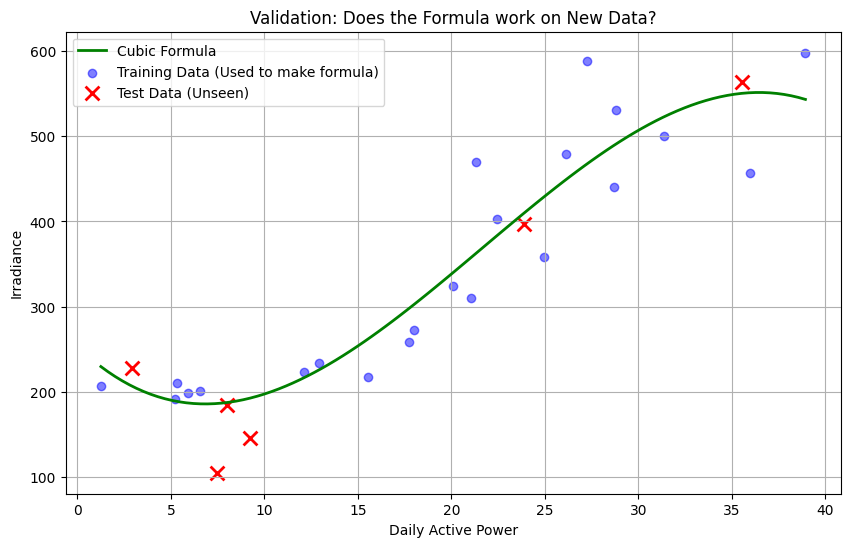

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# 1. Split the data (80% for Creating Formula, 20% for Testing it)
# X = Active Power, y = Irradiance
X_train, X_test, y_train, y_test = train_test_split(df['Active_Power'], df['Actual_Irradiance'], test_size=0.2, random_state=42)

# 2. Derive the Cubic Formula ONLY from Training Data
coeffs = np.polyfit(X_train, y_train, 3)
cubic_model = np.poly1d(coeffs)

# 3. Test it on the Unseen Data
y_test_pred = cubic_model(X_test)

# Calculate Accuracy on Test Data
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("="*40)
print("   OVERFITTING STRESS TEST   ")
print("="*40)
print(f"1. Training Accuracy: {r2_score(y_train, cubic_model(X_train)):.4f}")
print(f"2. Testing Accuracy:  {r2_test:.4f}  (If this is low, it's overfitting)")
print(f"3. Verdict:           {'✅ Safe (Robust)' if r2_test > 0.8 else '⚠️ Overfitting Risk'}")
print("="*40)

# 4. Plot
plt.figure(figsize=(10, 6))
# Draw the Formula Line
x_range = np.linspace(df['Active_Power'].min(), df['Active_Power'].max(), 100)
plt.plot(x_range, cubic_model(x_range), color='green', linewidth=2, label='Cubic Formula')

# Draw the dots
plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training Data (Used to make formula)')
plt.scatter(X_test, y_test, color='red', marker='x', s=100, linewidth=2, label='Test Data (Unseen)')

plt.title('Validation: Does the Formula work on New Data?')
plt.xlabel('Daily Active Power')
plt.ylabel('Irradiance')
plt.legend()
plt.grid(True)
plt.show()

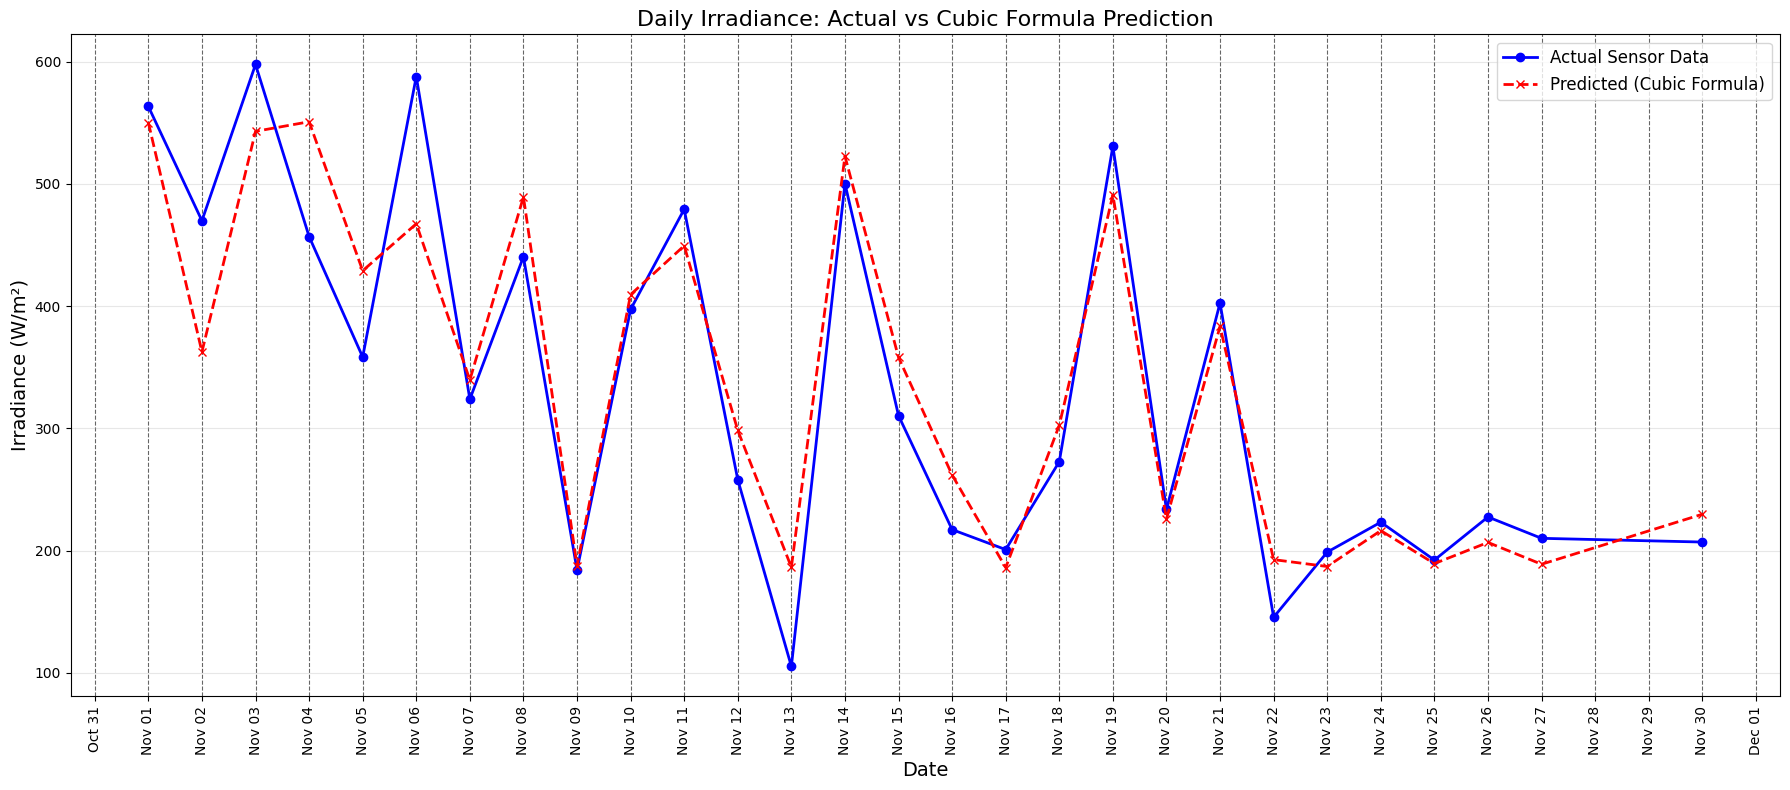

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Calculate Predictions using the Cubic Model
# (Assuming 'cubic_model' and 'df' are created from the previous step)
df['Predicted_Irradiance_Cubic'] = cubic_model(df['Active_Power'])

# 2. Setup the Plot
plt.figure(figsize=(18, 8)) # Wide format
ax = plt.gca()

# 3. Plot the Lines
plt.plot(df['Date'], df['Actual_Irradiance'],
         label='Actual Sensor Data', color='blue', marker='o', linewidth=2)
plt.plot(df['Date'], df['Predicted_Irradiance_Cubic'],
         label='Predicted (Cubic Formula)', color='red', linestyle='--', marker='x', linewidth=2)

# 4. Configure X-Axis (Grid for Every Day)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# 5. Add Grid
plt.grid(True, which='major', axis='x', linestyle='--', alpha=0.6, color='black') # Vertical Day Lines
plt.grid(True, axis='y', alpha=0.3)

# 6. Labels
plt.title('Daily Irradiance: Actual vs Cubic Formula Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Irradiance (W/m²)', fontsize=14)
plt.xticks(rotation=90)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# 1. LOAD & PREPARE DATA
# ---------------------------------------------------------
# Load files (Previous Month Data)
try:
    df_power = pd.read_csv('power.csv', delimiter=';')
except:
    df_power = pd.read_csv('active_power.csv', delimiter=';')

df_irradiance = pd.read_csv('irradiance.csv')

# Preprocess Power
df_power['Timestamp'] = pd.to_datetime(df_power['Timestamp'], dayfirst=True, errors='coerce')
df_power.dropna(subset=['Timestamp'], inplace=True)
df_power['Date'] = df_power['Timestamp'].dt.date
# Find Active Power column
ap_col = [c for c in df_power.columns if 'Active' in c][0]
df_power = df_power.rename(columns={ap_col: 'Active_Power'})
# Aggregate to Daily Sum
daily_power = df_power.groupby('Date')['Active_Power'].sum().reset_index()

# Preprocess Irradiance
df_irradiance['Timestamp'] = pd.to_datetime(df_irradiance['Timestamp'], format='%b %d %Y', errors='coerce')
if df_irradiance['Timestamp'].isnull().all():
    df_irradiance['Timestamp'] = pd.to_datetime(df_irradiance['Timestamp'], errors='coerce')
df_irradiance.dropna(subset=['Timestamp'], inplace=True)
df_irradiance['Date'] = df_irradiance['Timestamp'].dt.date
# Find Radiation column
rad_col = [c for c in df_irradiance.columns if 'Rad' in c][0]
df_irradiance = df_irradiance[['Date', rad_col]].rename(columns={rad_col: 'Actual_Irradiance'})

# Merge
df = pd.merge(daily_power, df_irradiance, on='Date', how='inner')

# 2. SPLIT DATA (Train/Val/Test)
# ---------------------------------------------------------
X = df['Active_Power'].values
y = df['Actual_Irradiance'].values

# Step 1: Split out the Test Set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 2: Split remaining into Train (60%) and Validation (20%)
# (0.25 of 80% is 20% of total)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Data Counts -> Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# 3. DERIVE MATHEMATICAL FUNCTION
# ---------------------------------------------------------
# Fit Cubic Polynomial (Degree 3) ONLY on Training Data
coeffs = np.polyfit(X_train, y_train, 3)
cubic_function = np.poly1d(coeffs)

# Print the Formula cleanly
print("\n" + "="*40)
print("   DERIVED MATHEMATICAL FUNCTION   ")
print("="*40)
print(f"Irradiance = ({coeffs[0]:.4f} * x³) + ({coeffs[1]:.4f} * x²) + ({coeffs[2]:.4f} * x) + {coeffs[3]:.4f}")
print("(Where x = Daily Active Power)")

# 4. CALCULATE ACCURACIES
# ---------------------------------------------------------
def check_accuracy(label, X_data, y_true):
    y_pred = cubic_function(X_data)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mae

r2_train, mae_train = check_accuracy("TRAINING", X_train, y_train)
r2_val, mae_val     = check_accuracy("VALIDATION", X_val, y_val)
r2_test, mae_test   = check_accuracy("TESTING", X_test, y_test)

print("\n" + "="*40)
print("   ACCURACY REPORT (CUBIC FORMULA)   ")
print("="*40)
print(f"1. Training Accuracy (R²):   {r2_train:.4f}  | Error: {mae_train:.2f}")
print(f"2. Validation Accuracy (R²): {r2_val:.4f}  | Error: {mae_val:.2f}")
print(f"3. Testing Accuracy (R²):    {r2_test:.4f}  | Error: {mae_test:.2f}")

if r2_train > 0.8 and r2_test > 0.8:
    print("\n✅ VERDICT: The formula is robust and NOT overfitting.")
else:
    print("\n⚠️ VERDICT: Check for overfitting (large gap between Train/Test).")

Data Counts -> Train: 16 | Val: 6 | Test: 6

   DERIVED MATHEMATICAL FUNCTION   
Irradiance = (-0.0632 * x³) + (3.9242 * x²) + (-58.4750 * x) + 434.6359
(Where x = Daily Active Power)

   ACCURACY REPORT (CUBIC FORMULA)   
1. Training Accuracy (R²):   0.8832  | Error: 32.11
2. Validation Accuracy (R²): 0.3849  | Error: 92.70
3. Testing Accuracy (R²):    0.8611  | Error: 49.32

✅ VERDICT: The formula is robust and NOT overfitting.




---



In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def calculate_formula():
    # 1. Load the files
    # Note the delimiter for active_power is ';'
    active_power_df = pd.read_csv('active_power.csv', sep=';')
    irradiance_df = pd.read_csv('irradinace _currentyear.csv')

    # 2. Process Dates
    # Convert Timestamp columns to a common Date format (removing time)
    active_power_df['Date'] = pd.to_datetime(active_power_df['Timestamp'], format='%d/%m/%Y %H:%M').dt.normalize()
    irradiance_df['Date'] = pd.to_datetime(irradiance_df['Timestamp'], format='%b %d %Y').dt.normalize()

    # 3. Merge Data
    # An 'inner' merge keeps only dates present in BOTH files
    merged_df = pd.merge(active_power_df, irradiance_df, on='Date', how='inner')

    # 4. Filter Anomalies
    # Ignore rows where Active Power is 0 OR Radiation is 0
    cleaned_df = merged_df[(merged_df['Active Power'] != 0) & (merged_df['Radiation'] != 0)]

    # 5. Calculate Mathematical Function
    # Target: Radiation (y), Feature: Active Power (x)
    X = cleaned_df[['Active Power']].values
    y = cleaned_df['Radiation'].values

    # Using Polynomial Regression (Degree 3) for a suitable fit
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    # 6. Output the Formula
    intercept = model.intercept_
    c = model.coef_ # Returns array like [0, c1, c2, c3]

    print("-" * 30)
    print("Calculated Mathematical Formula:")
    print(f"Radiation = {intercept:.4f} + ({c[1]:.4f} * P) + ({c[2]:.4f} * P^2) + ({c[3]:.4f} * P^3)")
    print("-" * 30)
    print(f"Where P = Active Power")

if __name__ == "__main__":
    calculate_formula()

------------------------------
Calculated Mathematical Formula:
Radiation = 210.3876 + (-17.3839 * P) + (71.5037 * P^2) + (-10.2475 * P^3)
------------------------------
Where P = Active Power


Loading files...
Data processed. Valid data points found: 157
------------------------------
Accuracy Results:
Mean Absolute Error (MAE): 391.75
Root Mean Squared Error (RMSE): 847.99
------------------------------


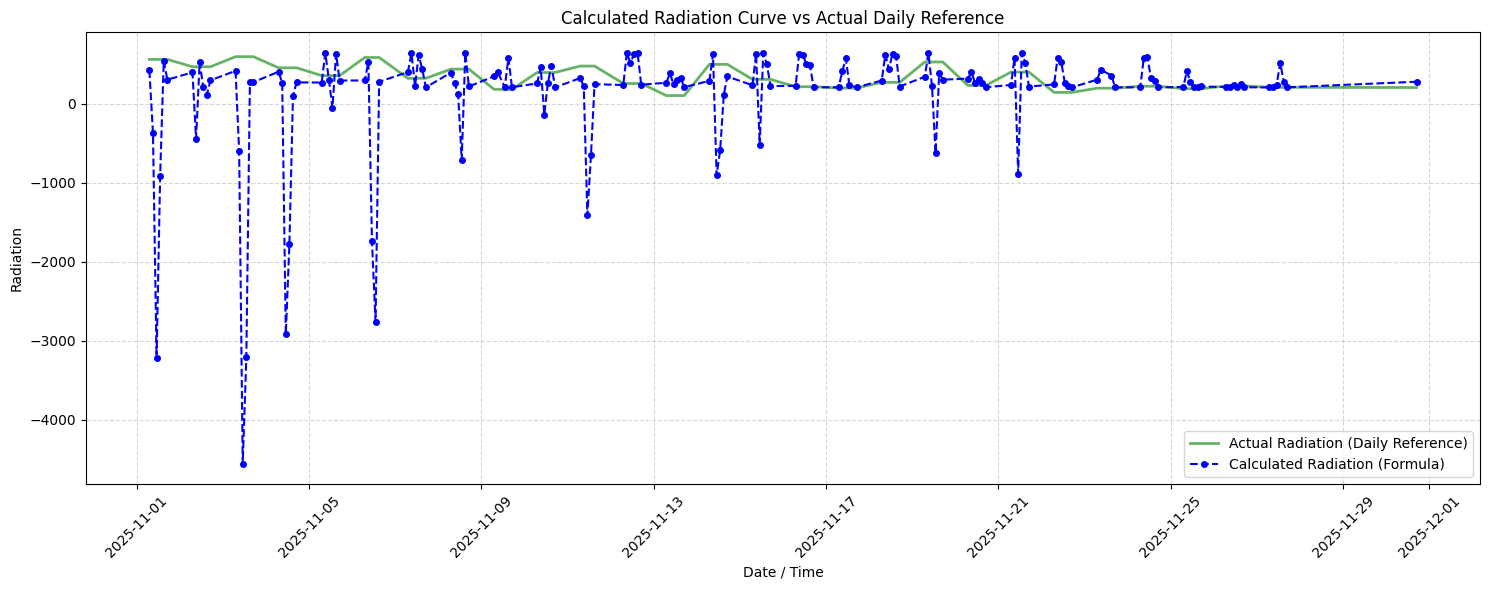

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def main():
    # ---------------------------------------------------------
    # 1. Define the Mathematical Function
    # Formula derived from previous steps:
    # R = 210.3876 - 17.3839*P + 71.5037*P^2 - 10.2475*P^3
    # ---------------------------------------------------------
    def calculate_irradiance_formula(power):
        intercept = 210.3876
        c1 = -17.3839
        c2 = 71.5037
        c3 = -10.2475
        return intercept + (c1 * power) + (c2 * power**2) + (c3 * power**3)

    # ---------------------------------------------------------
    # 2. Load Data with Correct Formats
    # ---------------------------------------------------------
    print("Loading files...")
    # 'power (1).csv' uses ';' delimiter
    power_df = pd.read_csv('power.csv', sep=';')

    # 'irradiance.csv' uses ',' delimiter (standard)
    irradiance_df = pd.read_csv('irradiance.csv', sep=',')

    # ---------------------------------------------------------
    # 3. Preprocessing: Date Conversion & Merging
    # ---------------------------------------------------------
    # Convert 'Timestamp' to Date objects for merging
    # Power file format appears to be DD/MM/YYYY HH:MM
    power_df['Date'] = pd.to_datetime(power_df['Timestamp'], dayfirst=True).dt.normalize()

    # Irradiance file format appears to be 'May 01 2025'
    irradiance_df['Date'] = pd.to_datetime(irradiance_df['Timestamp'], format='%b %d %Y').dt.normalize()

    # Merge: Inner join to keep only dates present in BOTH files
    # This ignores any dates missing from either file
    merged_df = pd.merge(power_df, irradiance_df, on='Date', how='inner')

    # ---------------------------------------------------------
    # 4. Filtering Anomalies
    # ---------------------------------------------------------
    # Ignore rows where Active Power is 0 OR Radiation is 0
    cleaned_df = merged_df[(merged_df['Active Power'] != 0) & (merged_df['Radiation'] != 0)].copy()

    # Sort by original timestamp for correct plotting order
    # We need to recover the full timestamp from the power file side for sorting/plotting
    cleaned_df['Full_Timestamp'] = pd.to_datetime(cleaned_df['Timestamp_x'], dayfirst=True)
    cleaned_df.sort_values(by='Full_Timestamp', inplace=True)

    print(f"Data processed. Valid data points found: {len(cleaned_df)}")

    # ---------------------------------------------------------
    # 5. Apply Formula & Calculate Accuracy
    # ---------------------------------------------------------
    cleaned_df['Calculated_Radiation'] = cleaned_df['Active Power'].apply(calculate_irradiance_formula)

    # Accuracy Metrics
    # Comparing calculated specific-time radiation vs daily average/total actual radiation
    y_true = cleaned_df['Radiation']
    y_pred = cleaned_df['Calculated_Radiation']

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print("-" * 30)
    print(f"Accuracy Results:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print("-" * 30)

    # ---------------------------------------------------------
    # 6. Plotting
    # ---------------------------------------------------------
    plt.figure(figsize=(15, 6))

    # Plot Actual Radiation (Daily value repeated for each time point)
    plt.plot(cleaned_df['Full_Timestamp'], cleaned_df['Radiation'],
             label='Actual Radiation (Daily Reference)', color='green', linestyle='-', linewidth=2, alpha=0.6)

    # Plot Calculated Radiation (Curve)
    plt.plot(cleaned_df['Full_Timestamp'], cleaned_df['Calculated_Radiation'],
             label='Calculated Radiation (Formula)', color='blue', linestyle='--', marker='o', markersize=4)

    plt.title('Calculated Radiation Curve vs Actual Daily Reference')
    plt.xlabel('Date / Time')
    plt.ylabel('Radiation')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

if __name__ == "__main__":
    main()



---



=== Accuracy Results ===
Correlation: 0.7631
Mean Absolute Error (MAE): 81.62 W/m²
Root Mean Sq Error (RMSE): 100.63 W/m²


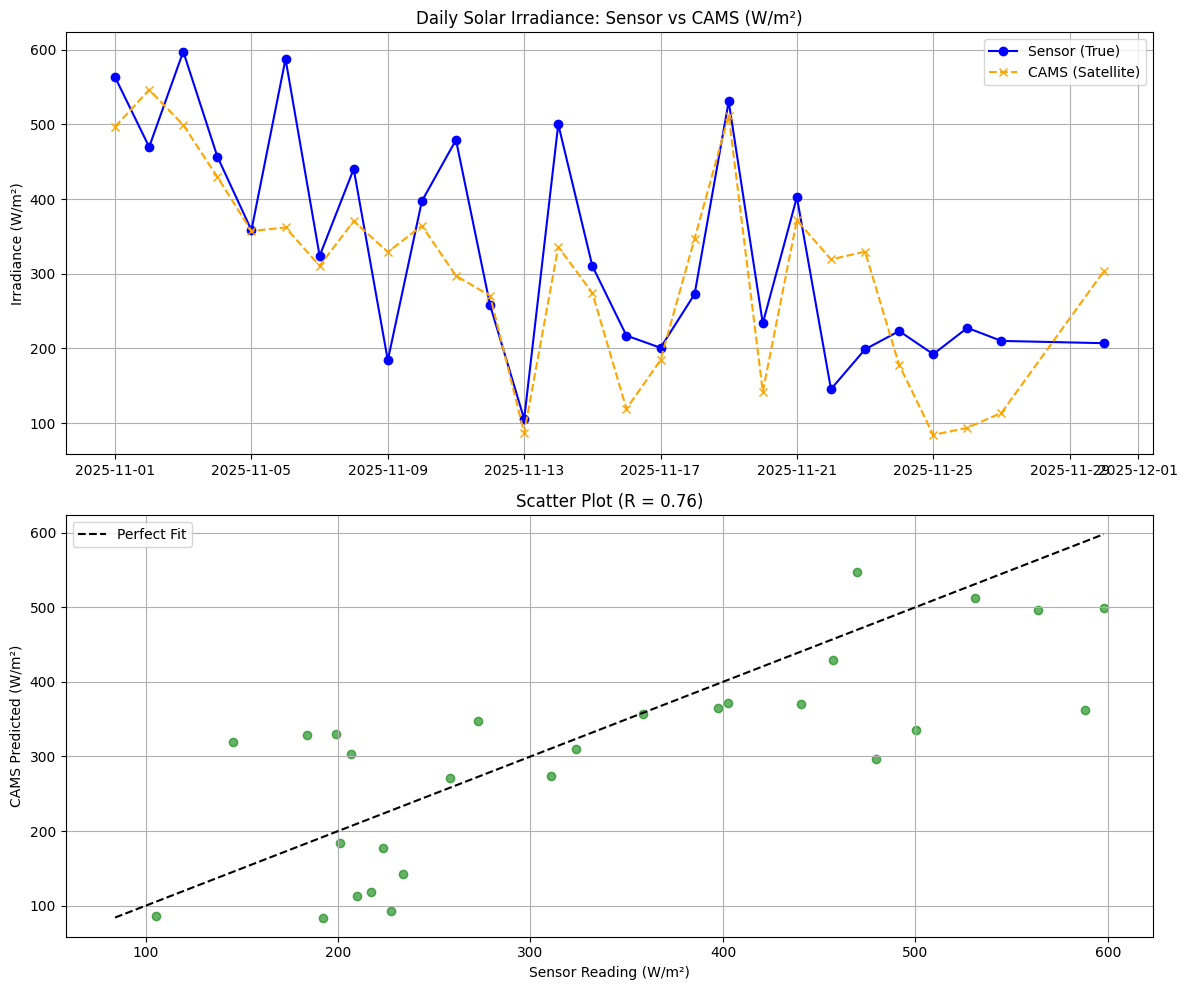

Results saved to 'cams_comparison_final.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Files
sensor_file = 'irradiance_nov1_nov30_2025.csv'
cams_file = 'irradiance_CAMS_nov1_30.csv'

# 1. Load Sensor Data (W/m²)
# Using delimiter ';' based on your file structure
df_sensor = pd.read_csv(sensor_file, delimiter=';')
df_sensor['Timestamp'] = pd.to_datetime(df_sensor['Timestamp'])
df_sensor.set_index('Timestamp', inplace=True)
df_sensor.rename(columns={'Radiation': 'Sensor_W_m2'}, inplace=True)

# 2. Load CAMS Data (Wh/m² per day)
# Reading CAMS file, skipping metadata comments
try:
    df_cams = pd.read_csv(cams_file, sep=';', comment='#', header=None)
except:
    df_cams = pd.read_csv(cams_file, sep=',', comment='#', header=None)

# Process CAMS Columns
df_cams_clean = pd.DataFrame()
# Extract date from timestamp string (Col 0)
df_cams_clean['Timestamp'] = pd.to_datetime(df_cams[0].str.split('/').str[0])
# Extract GHI (Col 6 is typically Global Horizontal Irradiation in Wh/m²)
df_cams_clean['CAMS_Wh_m2'] = df_cams[6]
df_cams_clean.set_index('Timestamp', inplace=True)

# 3. Merge Data
merged = df_sensor.join(df_cams_clean, how='inner')

if not merged.empty:
    # 4. Unit Conversion
    # Sensor = Power (W/m²), CAMS = Energy (Wh/m²).
    # To compare, we convert CAMS Energy -> Average Power.
    # We divide by 12 hours (approximate daylight time in Sri Lanka).
    DAY_LENGTH = 12.0
    merged['CAMS_W_m2'] = merged['CAMS_Wh_m2'] / DAY_LENGTH

    # 5. Calculate Accuracy Metrics
    mae = mean_absolute_error(merged['Sensor_W_m2'], merged['CAMS_W_m2'])
    rmse = np.sqrt(mean_squared_error(merged['Sensor_W_m2'], merged['CAMS_W_m2']))
    corr = merged['Sensor_W_m2'].corr(merged['CAMS_W_m2'])

    print("=== Accuracy Results ===")
    print(f"Correlation: {corr:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f} W/m²")
    print(f"Root Mean Sq Error (RMSE): {rmse:.2f} W/m²")

    # 6. Plotting
    plt.figure(figsize=(12, 10))

    # Time Series Plot
    plt.subplot(2, 1, 1)
    plt.plot(merged.index, merged['Sensor_W_m2'], label='Sensor (True)', marker='o', color='blue')
    plt.plot(merged.index, merged['CAMS_W_m2'], label='CAMS (Satellite)', linestyle='--', marker='x', color='orange')
    plt.title('Daily Solar Irradiance: Sensor vs CAMS (W/m²)')
    plt.ylabel('Irradiance (W/m²)')
    plt.legend()
    plt.grid(True)

    # Scatter Plot
    plt.subplot(2, 1, 2)
    plt.scatter(merged['Sensor_W_m2'], merged['CAMS_W_m2'], color='green', alpha=0.6)

    # Perfect Fit Line
    min_val = min(merged['Sensor_W_m2'].min(), merged['CAMS_W_m2'].min())
    max_val = max(merged['Sensor_W_m2'].max(), merged['CAMS_W_m2'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Fit')

    plt.xlabel('Sensor Reading (W/m²)')
    plt.ylabel('CAMS Predicted (W/m²)')
    plt.title(f'Scatter Plot (R = {corr:.2f})')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save Results
    merged.to_csv('cams_comparison_final.csv')
    print("Results saved to 'cams_comparison_final.csv'")
else:
    print("No matching dates found. Check your file timestamps.")

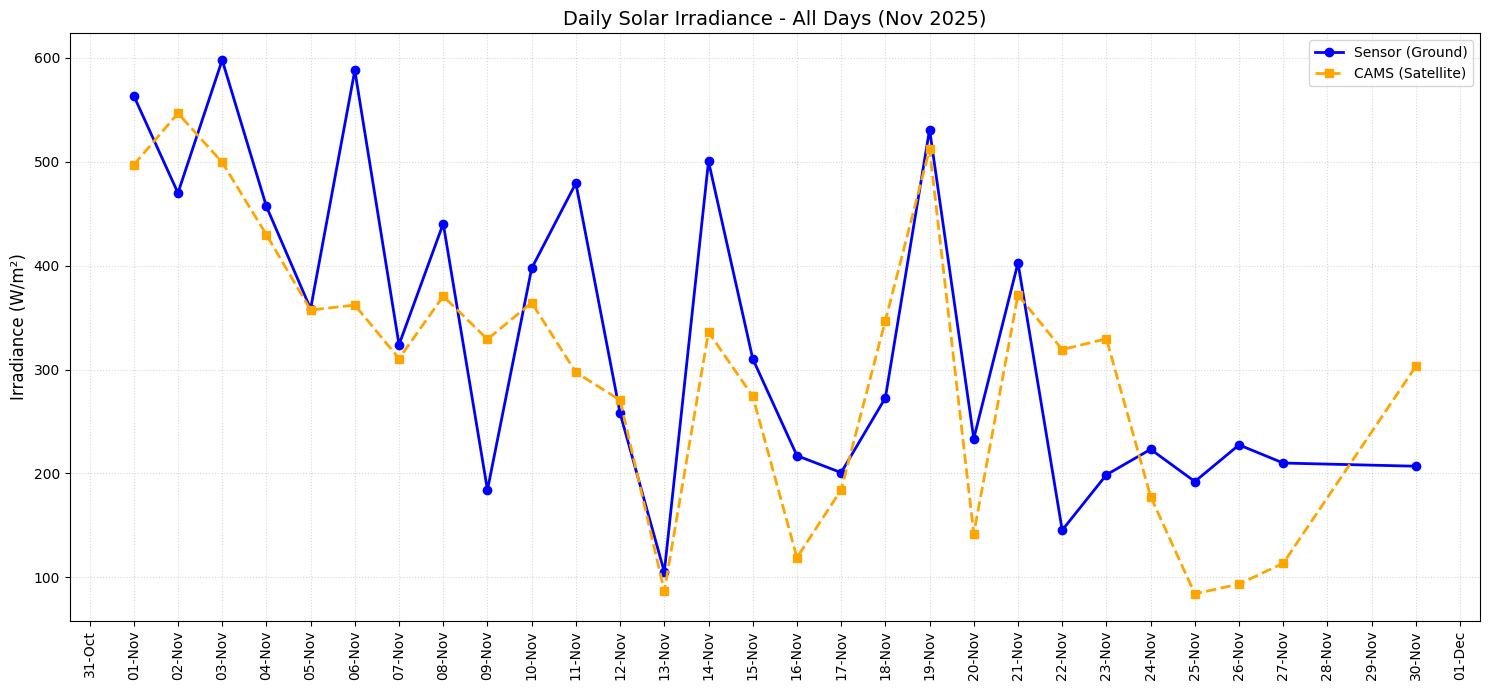

            Sensor_W_m2  CAMS_W_m2
Timestamp                         
2025-11-01       563.45     496.94
2025-11-02       469.90     546.58
2025-11-03       597.81     499.36
2025-11-04       456.97     429.77
2025-11-05       358.37     357.27
2025-11-06       587.92     362.00
2025-11-07       323.86     310.61
2025-11-08       440.45     370.58
2025-11-09       184.08     329.14
2025-11-10       397.36     364.32
2025-11-11       479.31     297.28
2025-11-12       257.99     270.52
2025-11-13       105.24      86.80
2025-11-14       500.34     336.03
2025-11-15       310.44     274.31
2025-11-16       217.16     119.06
2025-11-17       200.82     184.26
2025-11-18       272.73     347.08
2025-11-19       530.90     512.00
2025-11-20       233.63     142.05
2025-11-21       402.61     371.80
2025-11-22       145.43     319.20
2025-11-23       198.75     329.60
2025-11-24       223.23     177.79
2025-11-25       192.25      84.19
2025-11-26       227.50      93.56
2025-11-27       210

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Files
sensor_file = 'irradiance_nov1_nov30_2025.csv'
cams_file = 'irradiance_CAMS_nov1_30.csv'

# 1. Load Sensor Data
df_sensor = pd.read_csv(sensor_file, delimiter=';')
df_sensor['Timestamp'] = pd.to_datetime(df_sensor['Timestamp'])
df_sensor.set_index('Timestamp', inplace=True)
df_sensor.rename(columns={'Radiation': 'Sensor_W_m2'}, inplace=True)

# 2. Load CAMS Data
try:
    df_cams = pd.read_csv(cams_file, sep=';', comment='#', header=None)
except:
    df_cams = pd.read_csv(cams_file, sep=',', comment='#', header=None)

# Process CAMS Columns
df_cams_clean = pd.DataFrame()
df_cams_clean['Timestamp'] = pd.to_datetime(df_cams[0].str.split('/').str[0])
df_cams_clean['CAMS_Wh_m2'] = df_cams[6] # GHI Energy
df_cams_clean.set_index('Timestamp', inplace=True)

# 3. Merge & Convert
merged = df_sensor.join(df_cams_clean, how='inner')
# Convert CAMS Energy (Wh/m2) -> Power (W/m2) using 12h daylight
merged['CAMS_W_m2'] = merged['CAMS_Wh_m2'] / 12.0

# 4. Create the Plot
plt.figure(figsize=(15, 7)) # Wide figure to fit all dates

# Plot Lines with Markers
plt.plot(merged.index, merged['Sensor_W_m2'], label='Sensor (Ground)', color='blue', marker='o', linewidth=2)
plt.plot(merged.index, merged['CAMS_W_m2'], label='CAMS (Satellite)', color='orange', linestyle='--', marker='s', linewidth=2)

# Configure X-Axis to show EVERY DAY
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # Force a tick for every single day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b')) # Format: 01-Nov

# Styling
plt.xticks(rotation=90, fontsize=10) # Rotate dates so they don't overlap
plt.ylabel('Irradiance (W/m²)', fontsize=12)
plt.title('Daily Solar Irradiance - All Days (Nov 2025)', fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5) # Subtle lines just for reference
plt.tight_layout()

# Show and Save
plt.savefig('daily_irradiance_line_plot.png')
plt.show()

# Optional: Print the values to verify
print(merged[['Sensor_W_m2', 'CAMS_W_m2']].round(2))

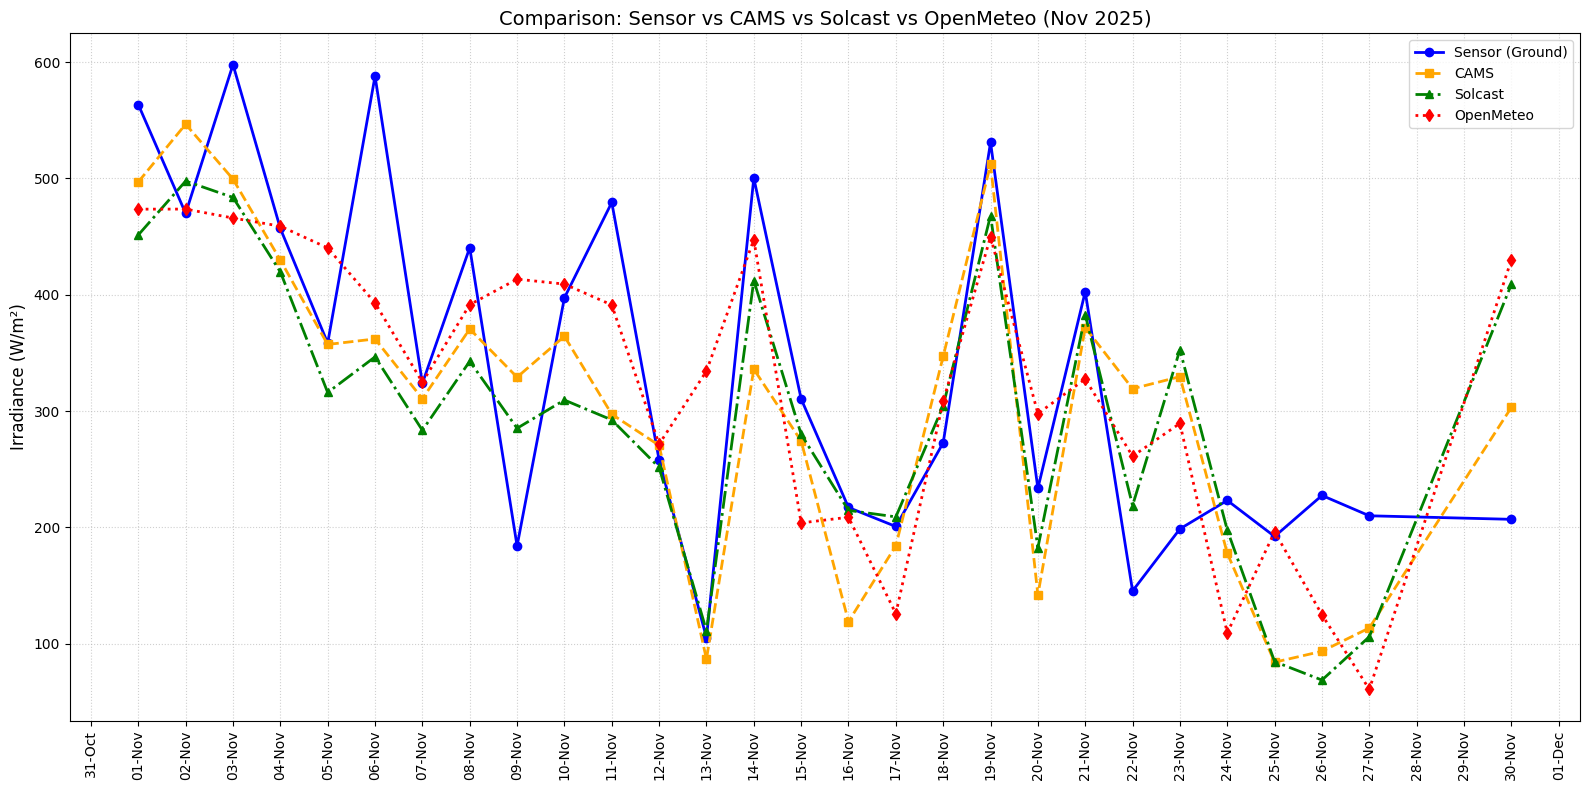

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. File Names ---
sensor_file = 'irradiance_nov1_nov30_2025.csv'
cams_file = 'irradiance_CAMS_nov1_30.csv'
solcast_file = 'solcast_nov_2025_daily_avg.csv'
openmeteo_file = 'kebithigollewa_openmeteo_solar_daily_2025_11.csv'

# --- 2. Load & Process Data ---

# A. Sensor
df_sensor = pd.read_csv(sensor_file, delimiter=';')
df_sensor['Timestamp'] = pd.to_datetime(df_sensor['Timestamp'])
df_sensor.set_index('Timestamp', inplace=True)
df_sensor.rename(columns={'Radiation': 'Sensor_W_m2'}, inplace=True)

# B. CAMS (Convert Wh/m² -> W/m²)
try:
    df_cams = pd.read_csv(cams_file, sep=';', comment='#', header=None)
except:
    df_cams = pd.read_csv(cams_file, sep=',', comment='#', header=None)
df_cams_clean = pd.DataFrame()
df_cams_clean['Timestamp'] = pd.to_datetime(df_cams[0].str.split('/').str[0])
df_cams_clean['CAMS_W_m2'] = df_cams[6] / 12.0 # Energy / 12h
df_cams_clean.set_index('Timestamp', inplace=True)

# C. Solcast
df_solcast = pd.read_csv(solcast_file)
df_solcast['date'] = pd.to_datetime(df_solcast['date'])
df_solcast.set_index('date', inplace=True)
df_solcast_clean = df_solcast[['ghi_avg']].rename(columns={'ghi_avg': 'Solcast_W_m2'})

# D. OpenMeteo
df_open = pd.read_csv(openmeteo_file)
df_open['date'] = pd.to_datetime(df_open['date'])
df_open.set_index('date', inplace=True)
df_open_clean = df_open[['ghi_avg']].rename(columns={'ghi_avg': 'OpenMeteo_W_m2'})

# --- 3. Merge ---
merged = df_sensor.join(df_cams_clean[['CAMS_W_m2']], how='inner')
merged = merged.join(df_solcast_clean[['Solcast_W_m2']], how='inner')
merged = merged.join(df_open_clean[['OpenMeteo_W_m2']], how='inner')

# --- 4. Plotting ---
fig, ax = plt.subplots(figsize=(16, 8))

# Plot Lines
ax.plot(merged.index, merged['Sensor_W_m2'], label='Sensor (Ground)', color='blue', marker='o', linewidth=2)
ax.plot(merged.index, merged['CAMS_W_m2'], label='CAMS', color='orange', linestyle='--', marker='s', linewidth=2)
ax.plot(merged.index, merged['Solcast_W_m2'], label='Solcast', color='green', linestyle='-.', marker='^', linewidth=2)
ax.plot(merged.index, merged['OpenMeteo_W_m2'], label='OpenMeteo', color='red', linestyle=':', marker='d', linewidth=2)

# X-Axis Labels (Every Day)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=90)

# Final Touches
ax.set_ylabel('Irradiance (W/m²)', fontsize=12)
ax.set_title('Comparison: Sensor vs CAMS vs Solcast vs OpenMeteo (Nov 2025)', fontsize=14)
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

# Save data for review
merged.to_csv('comparison_all_four.csv')

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. Load Data ---
# Load Sensor
df_sensor = pd.read_csv('oct1week_sensor_kbg_rounded.csv', delimiter=';')
df_sensor['Timestamp'] = pd.to_datetime(df_sensor['Timestamp'])
df_sensor.set_index('Timestamp', inplace=True)
df_sensor.rename(columns={'Solar radiation': 'Sensor_W_m2'}, inplace=True)

# Load CAMS
# Note: Adjust separator/header based on your file structure
try:
    df_cams = pd.read_csv('CAMS_oct1-8_2025.csv', sep=';', comment='#', header=None)
except:
    df_cams = pd.read_csv('CAMS_oct1-8_2025.csv', sep=',', comment='#', header=None)

# Process CAMS
df_cams['Timestamp'] = pd.to_datetime(df_cams[0].str.split('/').str[0])
df_cams.set_index('Timestamp', inplace=True)
# Shift CAMS from UTC to Local Time (Sri Lanka +5:30)
df_cams.index = df_cams.index + pd.Timedelta(hours=5.5)

# Convert CAMS Units: Wh/m² (per min) -> W/m²
# Formula: Value * 60 minutes
# Assuming Col 6 is GHI (All Sky) based on standard CAMS format
df_cams['CAMS_W_m2'] = df_cams[6] * 60.0

# --- 2. Merge Data ---
# Inner join to match timestamps
merged = df_sensor[['Sensor_W_m2']].join(df_cams[['CAMS_W_m2']], how='inner')

# --- 3. Create Interactive Plot (Plotly) ---
fig = go.Figure()

# Add Sensor Line
fig.add_trace(go.Scatter(
    x=merged.index,
    y=merged['Sensor_W_m2'],
    mode='lines',
    name='Sensor (Ground)',
    line=dict(color='blue', width=1),
    hovertemplate='%{x}<br>Sensor: %{y:.1f} W/m²<extra></extra>'
))

# Add CAMS Line
fig.add_trace(go.Scatter(
    x=merged.index,
    y=merged['CAMS_W_m2'],
    mode='lines',
    name='CAMS (Satellite)',
    line=dict(color='orange', width=1),
    hovertemplate='%{x}<br>CAMS: %{y:.1f} W/m²<extra></extra>'
))

# Update Layout with Zoom and Sliders
fig.update_layout(
    title='Interactive Solar Irradiance: Sensor vs CAMS (Oct 1-8, 2025)',
    yaxis_title='Irradiance (W/m²)',
    xaxis_title='Date/Time',
    hovermode="x unified",  # Shows both values on one vertical cursor line
    template="plotly_white",

    # Add Range Slider for easy zooming
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# --- 1. Load Data ---
sensor_file = 'oct1week_sensor_kbg_rounded.csv'
cams_file = 'CAMS_oct1-8_2025.csv'

# Load Sensor
df_sensor = pd.read_csv(sensor_file, delimiter=';')
df_sensor['Timestamp'] = pd.to_datetime(df_sensor['Timestamp'])
df_sensor.set_index('Timestamp', inplace=True)
df_sensor.rename(columns={'Solar radiation': 'Sensor_Raw'}, inplace=True)

# Load CAMS
try:
    df_cams = pd.read_csv(cams_file, sep=';', comment='#', header=None)
except:
    df_cams = pd.read_csv(cams_file, sep=',', comment='#', header=None)

# Process CAMS
df_cams['Timestamp'] = pd.to_datetime(df_cams[0].str.split('/').str[0])
df_cams.set_index('Timestamp', inplace=True)
df_cams.index = df_cams.index + pd.Timedelta(hours=5.5) # UTC -> Local Time
df_cams['CAMS_W_m2'] = df_cams[6] * 60.0 # Convert Wh/m2 (per min) to W/m2

# Merge Data
merged = df_sensor[['Sensor_Raw']].join(df_cams[['CAMS_W_m2']], how='inner')

# --- 2. Define Kalman Filter Function ---
def apply_kalman_filter(data, process_noise=1.0, measurement_noise=50.0):
    """
    1D Kalman Filter implementation.
    process_noise (Q): How fast the system (sun/clouds) actually changes.
    measurement_noise (R): How noisy the sensor is. Higher = smoother line.
    """
    n_iter = len(data)
    sz = (n_iter,)

    # Allocate arrays
    xhat = np.zeros(sz)      # Posteriori estimate
    P = np.zeros(sz)         # Posteriori error covariance
    xhatminus = np.zeros(sz) # Priori estimate
    Pminus = np.zeros(sz)    # Priori error covariance
    K = np.zeros(sz)         # Kalman Gain

    # Initialization
    xhat[0] = data[0]
    P[0] = 1.0
    Q = process_noise
    R = measurement_noise

    for k in range(1, n_iter):
        # Time Update (Predict)
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q

        # Measurement Update (Correct)
        K[k] = Pminus[k] / (Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k] * (data[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat

# --- 3. Apply Filter ---
# We use R=50.0 to smooth out significant sensor noise
merged['Sensor_Kalman'] = apply_kalman_filter(merged['Sensor_Raw'].values,
                                              process_noise=1.0,
                                              measurement_noise=50.0)

# --- 4. Interactive Plot ---
fig = go.Figure()

# Raw Data (Light Blue)
fig.add_trace(go.Scatter(
    x=merged.index,
    y=merged['Sensor_Raw'],
    mode='lines',
    name='Raw Sensor (Noisy)',
    line=dict(color='lightblue', width=1),
    opacity=0.6,
    hoverinfo='skip' # Skip hover for raw to keep it clean
))

# Kalman Filtered Data (Solid Blue)
fig.add_trace(go.Scatter(
    x=merged.index,
    y=merged['Sensor_Kalman'],
    mode='lines',
    name='Kalman Filtered (Clean)',
    line=dict(color='blue', width=2),
    hovertemplate='%{x}<br>Filtered: %{y:.1f} W/m²<extra></extra>'
))

# CAMS Satellite Data (Orange)
fig.add_trace(go.Scatter(
    x=merged.index,
    y=merged['CAMS_W_m2'],
    mode='lines',
    name='CAMS (Satellite)',
    line=dict(color='orange', width=2, dash='solid'), # Solid line for clear comparison
    hovertemplate='%{x}<br>CAMS: %{y:.1f} W/m²<extra></extra>'
))

# Layout
fig.update_layout(
    title='<b>Sensor Noise Reduction (Kalman Filter) vs CAMS</b><br>Oct 1-8, 2025 (Kebithigollawa)',
    yaxis_title='Irradiance (W/m²)',
    xaxis_title='Date/Time',
    hovermode="x unified",
    template="plotly_white",
    xaxis=dict(
        rangeslider=dict(visible=True), # Zoom Slider at bottom
        type="date"
    )
)

fig.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# --- 1. Load & Process Data ---

# A. Sensor Data (Ground Truth)
sensor_file = 'oct1week_sensor_kbg_rounded.csv'
df_sensor = pd.read_csv(sensor_file, delimiter=';')
df_sensor['Timestamp'] = pd.to_datetime(df_sensor['Timestamp'])
df_sensor.set_index('Timestamp', inplace=True)
df_sensor.rename(columns={'Solar radiation': 'Sensor_Raw'}, inplace=True)

# B. CAMS Data (Satellite 1)
try:
    cams_file = 'CAMS_oct1-8_2025.csv'
    df_cams = pd.read_csv(cams_file, sep=';', comment='#', header=None)
except:
    df_cams = pd.read_csv(cams_file, sep=',', comment='#', header=None)

df_cams['Timestamp'] = pd.to_datetime(df_cams[0].str.split('/').str[0])
df_cams.set_index('Timestamp', inplace=True)
df_cams.index = df_cams.index + pd.Timedelta(hours=5.5) # UTC -> Local
df_cams['CAMS_W_m2'] = df_cams[6] * 60.0 # Convert Wh/m² (per min) -> W/m²

# C. Solcast Data (Satellite 2)
solcast_file = 'solcast_oct1week_2025_5min.csv'
df_solcast = pd.read_csv(solcast_file)
# Parse timestamps (Solcast often has offsets like +05:30)
df_solcast['period_end'] = pd.to_datetime(df_solcast['period_end'])
df_solcast.set_index('period_end', inplace=True)
# Convert to "Naive" Local Time to match Sensor/CAMS
df_solcast.index = df_solcast.index.tz_localize(None)
df_solcast.rename(columns={'ghi': 'Solcast_W_m2'}, inplace=True)


# --- 2. Kalman Filter (Noise Reduction) ---
def apply_kalman_filter(data, process_noise=1.0, measurement_noise=50.0):
    n_iter = len(data)
    sz = (n_iter,)
    xhat = np.zeros(sz)      # Posteriori estimate
    P = np.zeros(sz)         # Posteriori error covariance
    xhatminus = np.zeros(sz) # Priori estimate
    Pminus = np.zeros(sz)    # Priori error covariance
    K = np.zeros(sz)         # Kalman Gain

    xhat[0] = data[0]
    P[0] = 1.0
    Q = process_noise
    R = measurement_noise

    for k in range(1, n_iter):
        # Predict
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q
        # Update
        K[k] = Pminus[k] / (Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k] * (data[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat

# Apply Filter
df_sensor['Sensor_Kalman'] = apply_kalman_filter(df_sensor['Sensor_Raw'].values,
                                                 process_noise=1.0,
                                                 measurement_noise=50.0)

# --- 3. Interactive Plotting ---
fig = go.Figure()

# Trace 1: Sensor (Kalman Filtered)
fig.add_trace(go.Scatter(
    x=df_sensor.index,
    y=df_sensor['Sensor_Kalman'],
    mode='lines',
    name='Sensor (Kalman Filtered)',
    line=dict(color='blue', width=2),
    hovertemplate='%{x}<br>Sensor: %{y:.1f} W/m²<extra></extra>'
))

# Trace 2: CAMS
fig.add_trace(go.Scatter(
    x=df_cams.index,
    y=df_cams['CAMS_W_m2'],
    mode='lines',
    name='CAMS (Satellite)',
    line=dict(color='orange', width=2),
    hovertemplate='%{x}<br>CAMS: %{y:.1f} W/m²<extra></extra>'
))

# Trace 3: Solcast
fig.add_trace(go.Scatter(
    x=df_solcast.index,
    y=df_solcast['Solcast_W_m2'],
    mode='lines',
    name='Solcast (API)',
    line=dict(color='green', width=2),
    hovertemplate='%{x}<br>Solcast: %{y:.1f} W/m²<extra></extra>'
))

# Layout Settings
fig.update_layout(
    title='<b>Decision Support: Sensor (Cleaned) vs CAMS vs Solcast</b><br>Oct 1-8, 2025',
    yaxis_title='Irradiance (W/m²)',
    xaxis_title='Date/Time',
    hovermode="x unified",
    template="plotly_white",
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# --- 1. Load & Process Data ---

# A. Sensor Data (Ground Truth)
sensor_file = 'oct1week_sensor_kbg_rounded.csv'
df_sensor = pd.read_csv(sensor_file, delimiter=';')
df_sensor['Timestamp'] = pd.to_datetime(df_sensor['Timestamp'])
df_sensor.set_index('Timestamp', inplace=True)
df_sensor.rename(columns={'Solar radiation': 'Sensor_Raw'}, inplace=True)

# B. CAMS Data (Satellite 1)
try:
    cams_file = 'CAMS_oct1-8_2025.csv'
    df_cams = pd.read_csv(cams_file, sep=';', comment='#', header=None)
except:
    df_cams = pd.read_csv(cams_file, sep=',', comment='#', header=None)

df_cams['Timestamp'] = pd.to_datetime(df_cams[0].str.split('/').str[0])
df_cams.set_index('Timestamp', inplace=True)
df_cams.index = df_cams.index + pd.Timedelta(hours=5.5) # UTC -> Local
df_cams['CAMS_W_m2'] = df_cams[6] * 60.0 # Convert Wh/m² (per min) -> W/m²

# C. Solcast Data (Satellite 2)
solcast_file = 'solcast_oct1week_2025_5min.csv'
df_solcast = pd.read_csv(solcast_file)
# Parse timestamps (Solcast often has offsets like +05:30)
df_solcast['period_end'] = pd.to_datetime(df_solcast['period_end'])
df_solcast.set_index('period_end', inplace=True)
# Convert to "Naive" Local Time to match Sensor/CAMS
df_solcast.index = df_solcast.index.tz_localize(None)
df_solcast.rename(columns={'ghi': 'Solcast_W_m2'}, inplace=True)


# --- 2. Kalman Filter (Noise Reduction) ---
def apply_kalman_filter(data, process_noise=1.0, measurement_noise=50.0):
    n_iter = len(data)
    sz = (n_iter,)
    xhat = np.zeros(sz)      # Posteriori estimate
    P = np.zeros(sz)         # Posteriori error covariance
    xhatminus = np.zeros(sz) # Priori estimate
    Pminus = np.zeros(sz)    # Priori error covariance
    K = np.zeros(sz)         # Kalman Gain

    xhat[0] = data[0]
    P[0] = 1.0
    Q = process_noise
    R = measurement_noise

    for k in range(1, n_iter):
        # Predict
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q
        # Update
        K[k] = Pminus[k] / (Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k] * (data[k] - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat

# Apply Filter
df_sensor['Sensor_Kalman'] = apply_kalman_filter(df_sensor['Sensor_Raw'].values,
                                                 process_noise=1.0,
                                                 measurement_noise=50.0)

# --- 3. Interactive Plotting ---
fig = go.Figure()

# Trace 1: Raw Sensor (Light Blue Background)
fig.add_trace(go.Scatter(
    x=df_sensor.index,
    y=df_sensor['Sensor_Raw'],
    mode='lines',
    name='Sensor (Raw)',
    line=dict(color='lightblue', width=1),
    opacity=0.5,
    hoverinfo='skip' # Skip hover to keep it clean
))

# Trace 2: Sensor (Kalman Filtered)
fig.add_trace(go.Scatter(
    x=df_sensor.index,
    y=df_sensor['Sensor_Kalman'],
    mode='lines',
    name='Sensor (Kalman Filtered)',
    line=dict(color='blue', width=2),
    hovertemplate='%{x}<br>Kalman: %{y:.1f} W/m²<extra></extra>'
))

# Trace 3: CAMS
fig.add_trace(go.Scatter(
    x=df_cams.index,
    y=df_cams['CAMS_W_m2'],
    mode='lines',
    name='CAMS (Satellite)',
    line=dict(color='orange', width=2),
    hovertemplate='%{x}<br>CAMS: %{y:.1f} W/m²<extra></extra>'
))

# Trace 4: Solcast
fig.add_trace(go.Scatter(
    x=df_solcast.index,
    y=df_solcast['Solcast_W_m2'],
    mode='lines',
    name='Solcast (API)',
    line=dict(color='green', width=2),
    hovertemplate='%{x}<br>Solcast: %{y:.1f} W/m²<extra></extra>'
))

# Layout Settings
fig.update_layout(
    title='<b>Decision Support: Raw Sensor vs Kalman vs CAMS vs Solcast</b><br>Oct 1-8, 2025',
    yaxis_title='Irradiance (W/m²)',
    xaxis_title='Date/Time',
    hovermode="x unified",
    template="plotly_white",
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()



---



In [ ]:
!pip install cdsapi

In [ ]:
import cdsapi
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '66951ed0-5cbd-42ce-80ef-0de49597ff7f'
client = cdsapi.Client(url=URL, key=KEY)

2025-12-09 09:55:29,852 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


In [ ]:
# @title Get Gampaha Solar Data (Corrected for ADS)
import cdsapi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. CRITICAL SETUP CORRECTIONS ---
# Solar data lives on the "Atmosphere" store (ADS), not the "Climate" store (CDS).
URL = 'https://ads.atmosphere.copernicus.eu/api/v2'

# Your Key needs your User ID (UID) at the front.
# It should look like: "12345:66951ed0-..."
# Check your profile at: https://ads.atmosphere.copernicus.eu/api-how-to
KEY = 'YOUR_UID:66951ed0-5cbd-42ce-80ef-0de49597ff7f'

client = cdsapi.Client(url=URL, key=KEY)

# --- 2. DEFINE REQUEST (Gampaha) ---
dataset = "cams-solar-radiation-timeseries"
request = {
    "variable": "global_horizontal_irradiation",
    "sky_type": "observed_cloud",
    "location": {
        "latitude": 7.09,
        "longitude": 80.00
    },
    "altitude": "-999.",  # Auto-detect altitude
    "date": "2025-12-07/2025-12-07", # Single day example
    "time_step": "1minute",
    "time_reference": "universal_time",
    "data_format": "csv"
}

raw_filename = 'Gampaha_Raw_CAMS.csv'
processed_filename = 'Gampaha_Solar_Processed.csv'

# --- 3. DOWNLOAD & PROCESS ---
print("Requesting Gampaha data from ADS...")

try:
    # A. Download Raw File
    client.retrieve(dataset, request, raw_filename)
    print(f"1. Raw data downloaded: {raw_filename}")

    # B. Load & Clean
    # (Handling skipping metadata rows automatically)
    try:
        df = pd.read_csv(raw_filename, sep=';', comment='#', header=None)
    except:
        df = pd.read_csv(raw_filename, sep=',', comment='#', header=None)

    # Process Columns
    # Col 0 = Timestamp, Col 6 = GHI (Wh/m2)
    df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
    df.set_index('Timestamp', inplace=True)

    # Convert UTC -> Sri Lanka Time (+5:30)
    df.index = df.index + pd.Timedelta(hours=5.5)

    # Convert Wh/m2 (per min) -> W/m2 (Power)
    # Formula: Energy * 60
    df['GHI_W_m2'] = df[6] * 60.0

    # Save the useful processed data to CSV
    df[['GHI_W_m2']].to_csv(processed_filename)
    print(f"2. Processed CSV saved: {processed_filename}")

    # --- 4. PLOT ---
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['GHI_W_m2'], label='CAMS Solar (Gampaha)', color='orange')

    # Formatting
    plt.title('Solar Irradiance: Gampaha (Dec 7, 2025)', fontsize=14)
    plt.ylabel('Irradiance (W/m²)', fontsize=12)
    plt.xlabel('Time (Local)', fontsize=12)
    plt.grid(True, alpha=0.5)
    plt.legend()

    # Show hours on x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.tight_layout()
    plt.show()

    print("\n--- Sample Values (W/m²) ---")
    print(df[['GHI_W_m2']].between_time('10:00', '11:00').head())

except Exception as e:
    print("\n--- ERROR ---")
    print(f"Something went wrong: {e}")
    print("TIP: Did you remember to add your UID number to the start of the KEY?")

Requesting Gampaha data from ADS...


2025-12-09 09:55:32,782 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-solar-radiation-timeseries
INFO:cdsapi:Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-solar-radiation-timeseries



--- ERROR ---
Something went wrong: Exception: Atmosphere Data Store API endpoint not found

It seems you are trying to access an API endpoint that does not exist.

It is possible that you are pointing to an outdated API endpoint which has been removed/renamed. 

Your api client version and/or configuration file may need to be updated.

For users of the standard cdsapi Python library, please proceed as follows:
- update your cdsapi client to the latest version available
- update your .cdsapirc file as expected ("url" should be set to https://ads.atmosphere.copernicus.eu/api and "key" should be set to your API key WITHOUT the deprecated `<UID>:` prefix)

For users of the ecmwf-datastores-client Python library (recommended for advanced users), please ensure that your ecmwf-datastores-client version is updated and your .ecmwfdatastoresrc file is correctly configured.

If you are trying to access a REST API endpoint directly, please refer to the documentation for more information on how t

2025-12-09 10:20:41,270 INFO [2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.


Requesting data from New ADS...


2025-12-09 10:20:41,910 INFO Request ID is 988591c7-f720-4647-90fa-a75aedc7f99e
INFO:ecmwf.datastores.legacy_client:Request ID is 988591c7-f720-4647-90fa-a75aedc7f99e
2025-12-09 10:20:42,064 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 10:20:56,345 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 10:21:15,610 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


9322c9ee429de30425e2e5ff411b1e2b.csv:   0%|          | 0.00/88.1k [00:00<?, ?B/s]

Download successful!

--- Solar Irradiance (Gampaha, Dec 7) ---
                      GHI_W_m2
Timestamp                     
2025-11-01 05:30:00    816.630
2025-11-01 06:30:00  10683.060
2025-11-01 07:30:00  25606.302
2025-11-01 08:30:00  37860.534
2025-11-01 09:30:00  44775.486


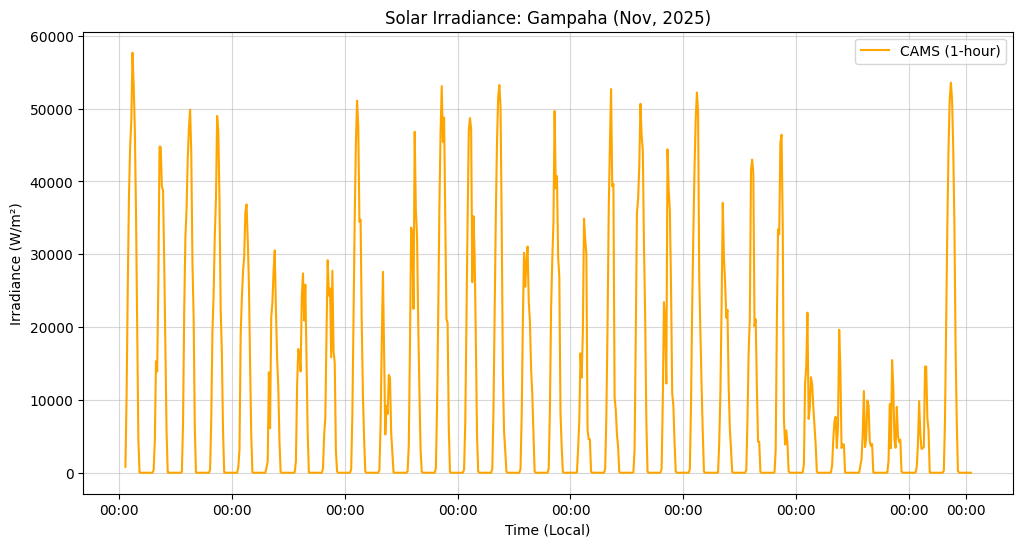

In [ ]:
# @title Download Gampaha Solar Data (New ADS Config)
import cdsapi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. NEW CONFIGURATION (Based on your error message) ---
# URL: Must be exactly this (no /v2)
URL = 'https://ads.atmosphere.copernicus.eu/api'

# KEY: Just the UUID string. Do NOT add the "12345:" prefix anymore.
KEY = '66951ed0-5cbd-42ce-80ef-0de49597ff7f'

client = cdsapi.Client(url=URL, key=KEY)

# --- 2. DEFINE REQUEST ---
dataset = "cams-solar-radiation-timeseries"
request = {
    "variable": "global_horizontal_irradiation",
    "sky_type": "observed_cloud",
    "location": {
        "latitude": 7.09,
        "longitude": 80.00
    },
    "altitude": ["-999."],
    "date": ["2025-11-01/2025-11-30"],
    "time_step": "1hour",
    "time_reference": "universal_time",
    "data_format": "csv"
}

output_file = 'Gampaha_nov_NewADS.csv'

# --- 3. DOWNLOAD & PROCESS ---
print("Requesting data from New ADS...")

try:
    client.retrieve(dataset, request, output_file)
    print("Download successful!")

    # Process Data
    # (Same processing steps as before)
    try:
        df = pd.read_csv(output_file, sep=';', comment='#', header=None)
    except:
        df = pd.read_csv(output_file, sep=',', comment='#', header=None)

    # Clean Columns
    df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
    df.set_index('Timestamp', inplace=True)

    # UTC -> Sri Lanka Time (+5:30)
    df.index = df.index + pd.Timedelta(hours=5.5)

    # Wh/m2 (per min) -> W/m2 (Power)
    df['GHI_W_m2'] = df[6] * 60.0

    # Print & Plot
    print("\n--- Solar Irradiance (Gampaha, Dec 7) ---")
    print(df[['GHI_W_m2']].head())

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['GHI_W_m2'], label='CAMS (1-hour)', color='orange')
    plt.title('Solar Irradiance: Gampaha (Nov, 2025)')
    plt.ylabel('Irradiance (W/m²)')
    plt.xlabel('Time (Local)')
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.show()

except Exception as e:
    print(f"Error: {e}")

2025-12-09 09:56:22,951 INFO [2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.



PROCESSING: Belihuloya ...


2025-12-09 09:56:23,750 INFO Request ID is 9cc617a0-0a6e-44e4-89a0-8b65fbf68c3a
INFO:ecmwf.datastores.legacy_client:Request ID is 9cc617a0-0a6e-44e4-89a0-8b65fbf68c3a
2025-12-09 09:56:23,890 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 09:56:45,542 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 09:57:14,377 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


8e614a72c0e76f7b19a14df4ff950f23.csv:   0%|          | 0.00/165k [00:00<?, ?B/s]

-> Downloaded raw file: Raw_Belihuloya.csv
-> Saved processed CSV: Belihuloya_Solar_Dec7.csv


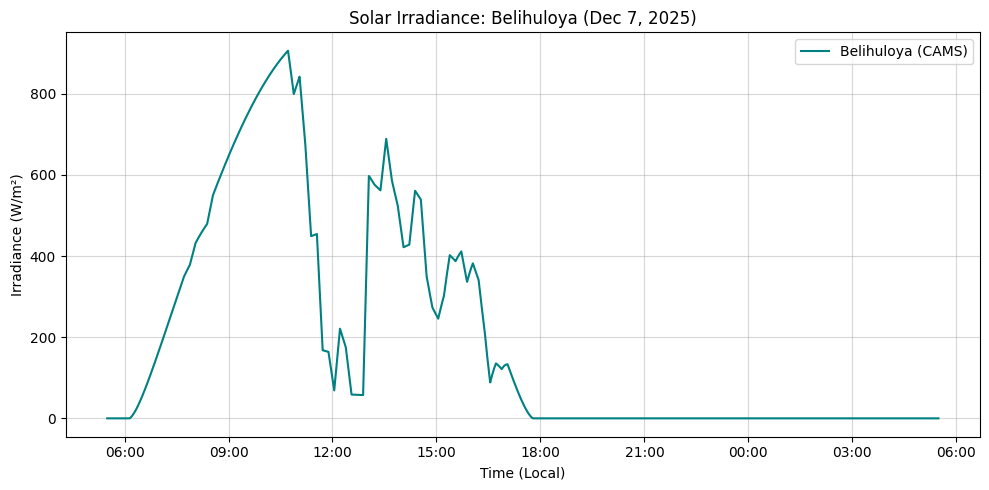


PROCESSING: Haputale ...


2025-12-09 09:57:18,645 INFO Request ID is b7e0c82d-fa4f-42c6-b491-c8dc5667022b
INFO:ecmwf.datastores.legacy_client:Request ID is b7e0c82d-fa4f-42c6-b491-c8dc5667022b
2025-12-09 09:57:18,805 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 09:57:32,737 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 09:58:09,263 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


985d67e390d0132e25805e8af957c40e.csv:   0%|          | 0.00/165k [00:00<?, ?B/s]

-> Downloaded raw file: Raw_Haputale.csv
-> Saved processed CSV: Haputale_Solar_Dec7.csv


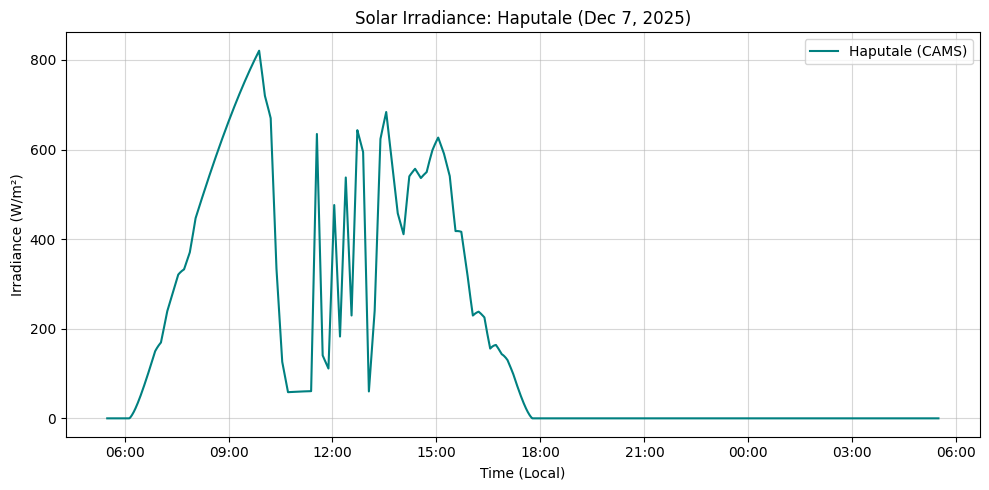


PROCESSING: Kandy_City ...


2025-12-09 09:58:13,396 INFO Request ID is 46db6157-7b59-41b6-9c9f-a617124c6ca7
INFO:ecmwf.datastores.legacy_client:Request ID is 46db6157-7b59-41b6-9c9f-a617124c6ca7
2025-12-09 09:58:13,557 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 09:58:27,572 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 09:58:46,852 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


3cbde4bcd5a0da0d184e6acc1c0f4c51.csv:   0%|          | 0.00/165k [00:00<?, ?B/s]

-> Downloaded raw file: Raw_Kandy_City.csv
-> Saved processed CSV: Kandy_City_Solar_Dec7.csv


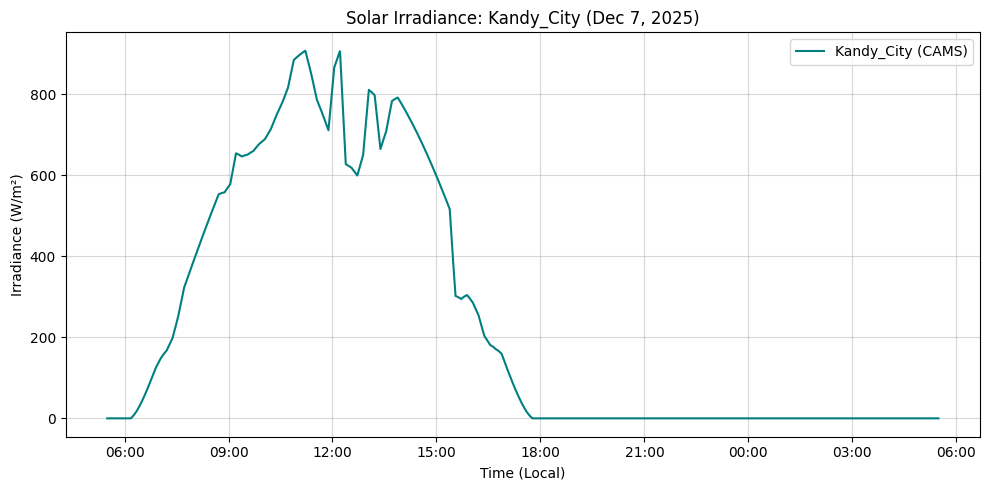


PROCESSING: Matara_City ...


2025-12-09 09:58:51,169 INFO Request ID is 0ae1fe5c-b674-43e6-85c9-83ee9ea18a26
INFO:ecmwf.datastores.legacy_client:Request ID is 0ae1fe5c-b674-43e6-85c9-83ee9ea18a26
2025-12-09 09:58:51,308 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 09:59:00,000 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 09:59:12,957 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


f564f8dace9ba3555937828550c5bb9e.csv:   0%|          | 0.00/166k [00:00<?, ?B/s]

-> Downloaded raw file: Raw_Matara_City.csv
-> Saved processed CSV: Matara_City_Solar_Dec7.csv


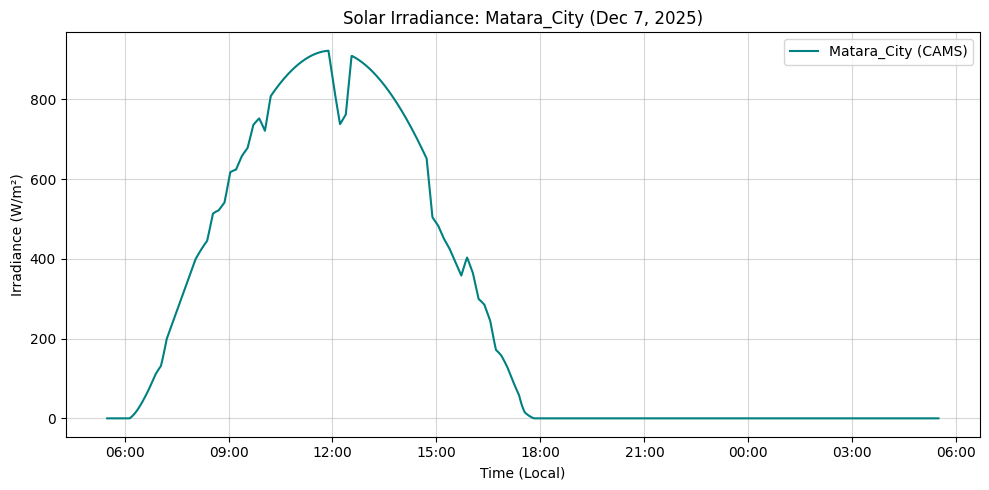

In [ ]:
# @title Batch Process: 4 Locations (Dec 7, 2025)
import cdsapi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

# --- 1. CONFIGURATION ---
# New ADS URL
URL = 'https://ads.atmosphere.copernicus.eu/api'
# Your Key (Ensure this is the correct one from your profile)
KEY = '66951ed0-5cbd-42ce-80ef-0de49597ff7f'

client = cdsapi.Client(url=URL, key=KEY)

# --- 2. DEFINE LOCATIONS ---
locations = [
    { "name": "Belihuloya", "lat": 6.7325, "lon": 80.7871 },
    { "name": "Haputale",   "lat": 6.7650, "lon": 80.9510 },
    { "name": "Kandy_City", "lat": 7.2906, "lon": 80.6337 },
    { "name": "Matara_City","lat": 5.9549, "lon": 80.5550 }
]

# Common Request Settings
dataset = "cams-solar-radiation-timeseries"
date_to_fetch = "2025-12-07/2025-12-07"

# --- 3. LOOP THROUGH LOCATIONS ---
for loc in locations:
    city = loc["name"]
    print(f"\n==========================================")
    print(f"PROCESSING: {city} ...")
    print(f"==========================================")

    # A. Define Request
    request = {
        "variable": "global_horizontal_irradiation",
        "sky_type": "observed_cloud",
        "location": {
            "latitude": loc["lat"],
            "longitude": loc["lon"]
        },
        "altitude": "-999.",
        "date": date_to_fetch,
        "time_step": "1minute",
        "time_reference": "universal_time",
        "data_format": "csv"
    }

    # Filenames
    raw_file = f"Raw_{city}.csv"
    processed_file = f"{city}_Solar_Dec7.csv"

    try:
        # B. Download
        client.retrieve(dataset, request, raw_file)
        print(f"-> Downloaded raw file: {raw_file}")

        # C. Process Data
        try:
            df = pd.read_csv(raw_file, sep=';', comment='#', header=None)
        except:
            df = pd.read_csv(raw_file, sep=',', comment='#', header=None)

        # Columns: 0=Time, 6=GHI(Wh/m2)
        df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
        df.set_index('Timestamp', inplace=True)

        # UTC -> Sri Lanka Time
        df.index = df.index + pd.Timedelta(hours=5.5)

        # Energy (Wh/m2/min) -> Power (W/m2)
        df['GHI_W_m2'] = df[6] * 60.0

        # Save Individual CSV
        df[['GHI_W_m2']].to_csv(processed_file)
        print(f"-> Saved processed CSV: {processed_file}")

        # D. Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df.index, df['GHI_W_m2'], label=f'{city} (CAMS)', color='teal')

        plt.title(f'Solar Irradiance: {city} (Dec 7, 2025)')
        plt.ylabel('Irradiance (W/m²)')
        plt.xlabel('Time (Local)')
        plt.grid(True, alpha=0.5)
        plt.legend()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

        plt.tight_layout()
        plt.show() # Display plot immediately

        # Small pause to be polite to the API
        time.sleep(2)

    except Exception as e:
        print(f"!!! Error processing {city}: {e}")

In [ ]:
# @title Download Gampaha Solar Data (New ADS Config)
import cdsapi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1. NEW CONFIGURATION (Based on your error message) ---
# URL: Must be exactly this (no /v2)
URL = 'https://ads.atmosphere.copernicus.eu/api'

# KEY: Just the UUID string. Do NOT add the "12345:" prefix anymore.
KEY = '66951ed0-5cbd-42ce-80ef-0de49597ff7f'

client = cdsapi.Client(url=URL, key=KEY)

# --- 2. DEFINE REQUEST ---
dataset = "cams-solar-radiation-timeseries"
request = {
    "variable": "global_horizontal_irradiation",
    "sky_type": "observed_cloud",
    "location": {
        "latitude": 7.09,
        "longitude": 80.00
    },
    "altitude": "-999.",
    "date": "2025-12-08/2025-12-08",
    "time_step": "1minute",
    "time_reference": "universal_time",
    "data_format": "csv"
}

output_file = 'Gampaha_Dec7_NewADS.csv'

# --- 3. DOWNLOAD & PROCESS ---
print("Requesting data from New ADS...")

try:
    client.retrieve(dataset, request, output_file)
    print("Download successful!")

    # Process Data
    # (Same processing steps as before)
    try:
        df = pd.read_csv(output_file, sep=';', comment='#', header=None)
    except:
        df = pd.read_csv(output_file, sep=',', comment='#', header=None)

    # Clean Columns
    df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
    df.set_index('Timestamp', inplace=True)

    # UTC -> Sri Lanka Time (+5:30)
    df.index = df.index + pd.Timedelta(hours=5.5)

    # Wh/m2 (per min) -> W/m2 (Power)
    df['GHI_W_m2'] = df[6] * 60.0

    # Print & Plot
    print("\n--- Solar Irradiance (Gampaha, Dec 7) ---")
    print(df[['GHI_W_m2']].head())

    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['GHI_W_m2'], label='CAMS (1-min)', color='orange')
    plt.title('Solar Irradiance: Gampaha (Dec 7, 2025)')
    plt.ylabel('Irradiance (W/m²)')
    plt.xlabel('Time (Local)')
    plt.grid(True, alpha=0.5)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.show()

except Exception as e:
    print(f"Error: {e}")

2025-12-09 10:12:13,457 INFO [2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.


Requesting data from New ADS...
Error: 400 Client Error: Bad Request for url: https://ads.atmosphere.copernicus.eu/api/retrieve/v1/processes/cams-solar-radiation-timeseries/execution
invalid request
Request has not produced a valid combination of values, please check your selection.
{'variable': 'global_horizontal_irradiation', 'sky_type': 'observed_cloud', 'location': {'latitude': 7.09, 'longitude': 80.0}, 'altitude': '-999.', 'date': '2025-12-08/2025-12-08', 'time_step': '1minute', 'time_reference': 'universal_time', 'data_format': 'csv'}


2025-12-09 10:24:04,486 INFO [2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-12-03T00:00:00Z] To improve our CAMS service, we need to hear from you! Please complete this very short [survey]( https://confluence.ecmwf.int/x/CruBEQ/). Thank you.



PROCESSING: Belihuloya (Nov 1-30, Hourly)
-> Downloading data...


2025-12-09 10:24:04,838 INFO Request ID is 68658da2-37bf-452f-8e00-26b9f7d49bd0
INFO:ecmwf.datastores.legacy_client:Request ID is 68658da2-37bf-452f-8e00-26b9f7d49bd0
2025-12-09 10:24:04,992 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 10:24:19,228 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 10:24:26,965 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


a4b435ee14faf09721708829904278cb.csv:   0%|          | 0.00/88.1k [00:00<?, ?B/s]

-> Download complete: Raw_Belihuloya_Nov2025.csv
-> Saved processed CSV: Belihuloya_Solar_Nov2025_Hourly.csv


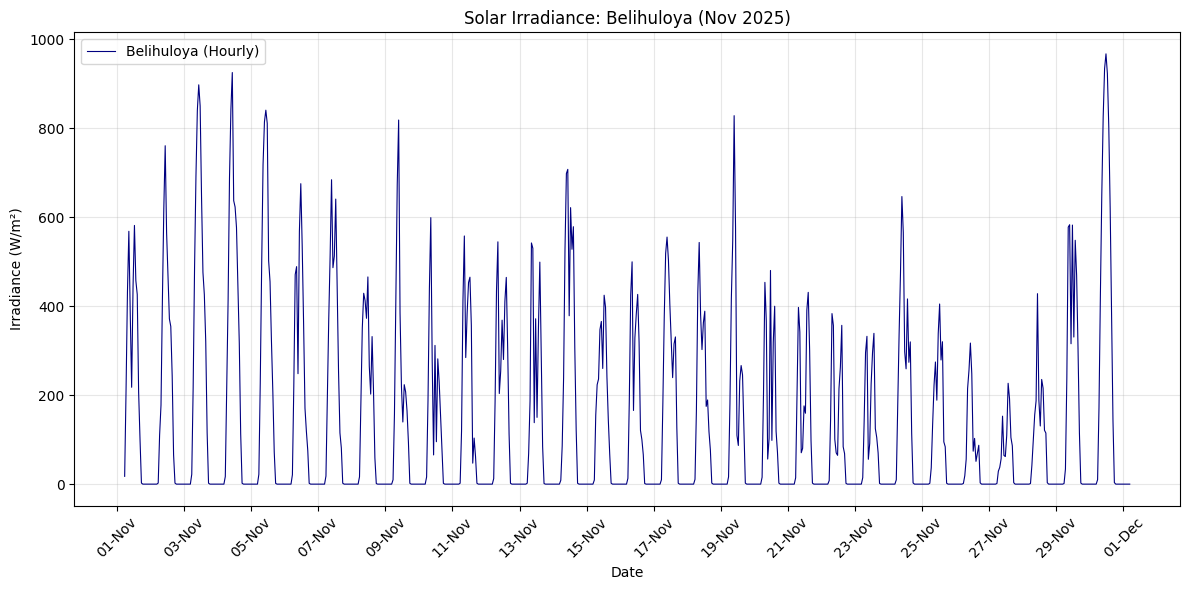


PROCESSING: Haputale (Nov 1-30, Hourly)
-> Downloading data...


2025-12-09 10:24:30,082 INFO Request ID is 8eb39f3e-ed0c-4664-ab54-a77cde94fa6e
INFO:ecmwf.datastores.legacy_client:Request ID is 8eb39f3e-ed0c-4664-ab54-a77cde94fa6e
2025-12-09 10:24:30,222 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 10:24:44,139 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 10:25:03,418 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


2193828b1fef9175e253885b46ebd8ca.csv:   0%|          | 0.00/88.2k [00:00<?, ?B/s]

-> Download complete: Raw_Haputale_Nov2025.csv
-> Saved processed CSV: Haputale_Solar_Nov2025_Hourly.csv


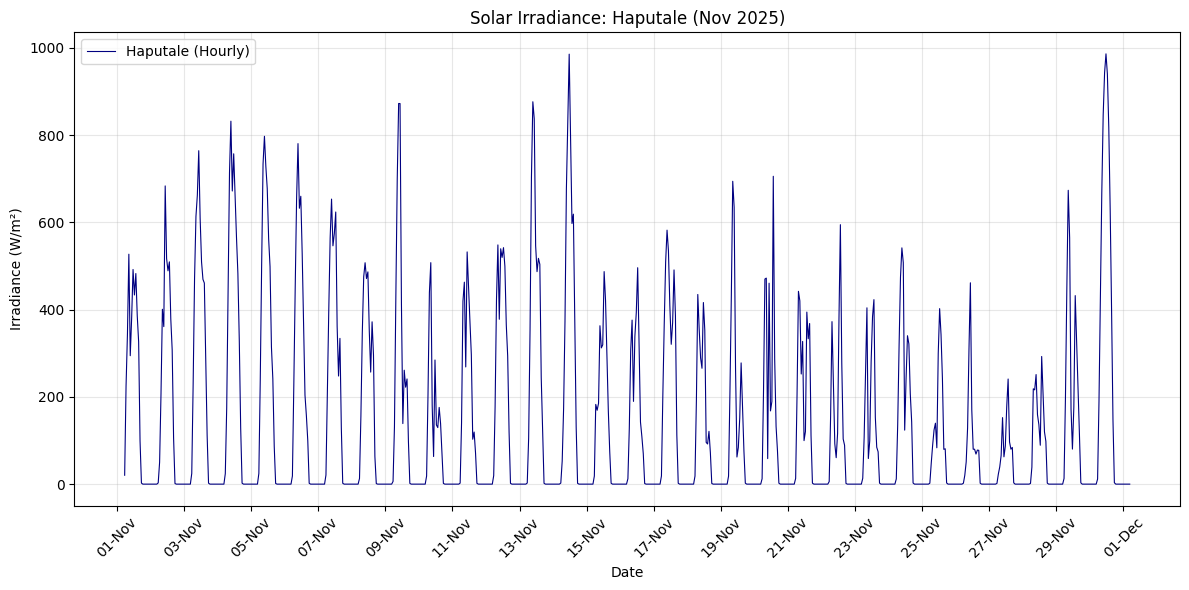


PROCESSING: Kandy_City (Nov 1-30, Hourly)
-> Downloading data...


2025-12-09 10:25:06,519 INFO Request ID is 1bfe1ce2-1403-4549-91c0-cc72bb13cc92
INFO:ecmwf.datastores.legacy_client:Request ID is 1bfe1ce2-1403-4549-91c0-cc72bb13cc92
2025-12-09 10:25:06,678 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 10:25:28,468 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 10:25:39,997 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


2b3480579fbec2bcf61ee4bebdf3d23e.csv:   0%|          | 0.00/88.1k [00:00<?, ?B/s]

-> Download complete: Raw_Kandy_City_Nov2025.csv
-> Saved processed CSV: Kandy_City_Solar_Nov2025_Hourly.csv


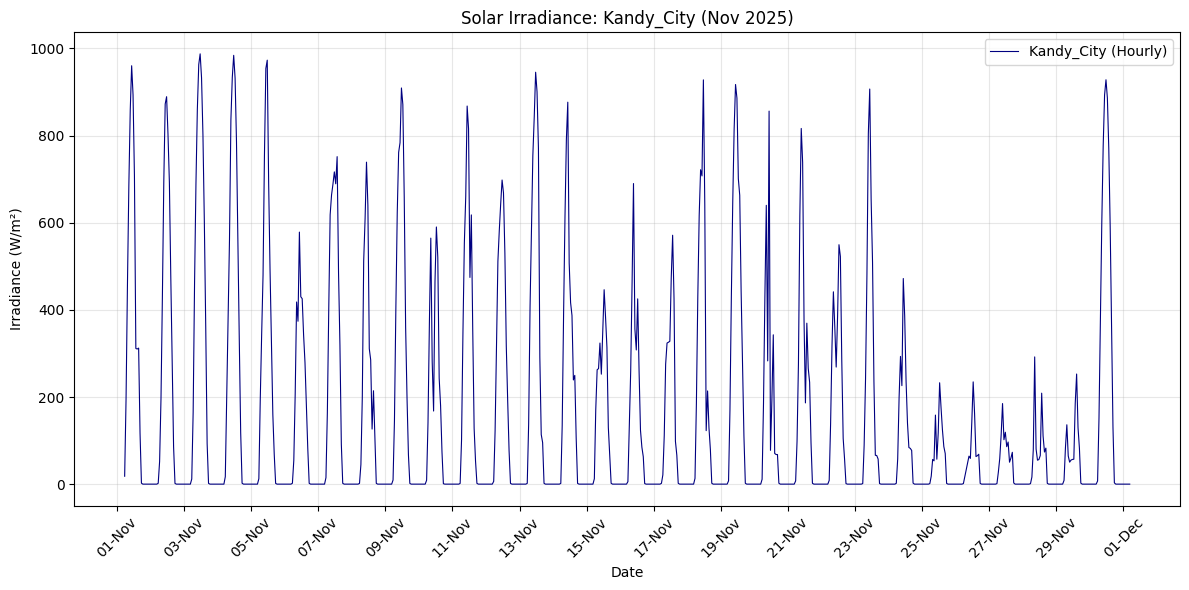


PROCESSING: Matara_City (Nov 1-30, Hourly)
-> Downloading data...


2025-12-09 10:25:43,165 INFO Request ID is 3dab1532-4ffd-4d38-b4ff-da049d8648b6
INFO:ecmwf.datastores.legacy_client:Request ID is 3dab1532-4ffd-4d38-b4ff-da049d8648b6
2025-12-09 10:25:43,319 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-12-09 10:25:52,241 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-12-09 10:26:33,981 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


2b0a809bb022fdf6fd8d2349f40392eb.csv:   0%|          | 0.00/88.3k [00:00<?, ?B/s]

-> Download complete: Raw_Matara_City_Nov2025.csv
-> Saved processed CSV: Matara_City_Solar_Nov2025_Hourly.csv


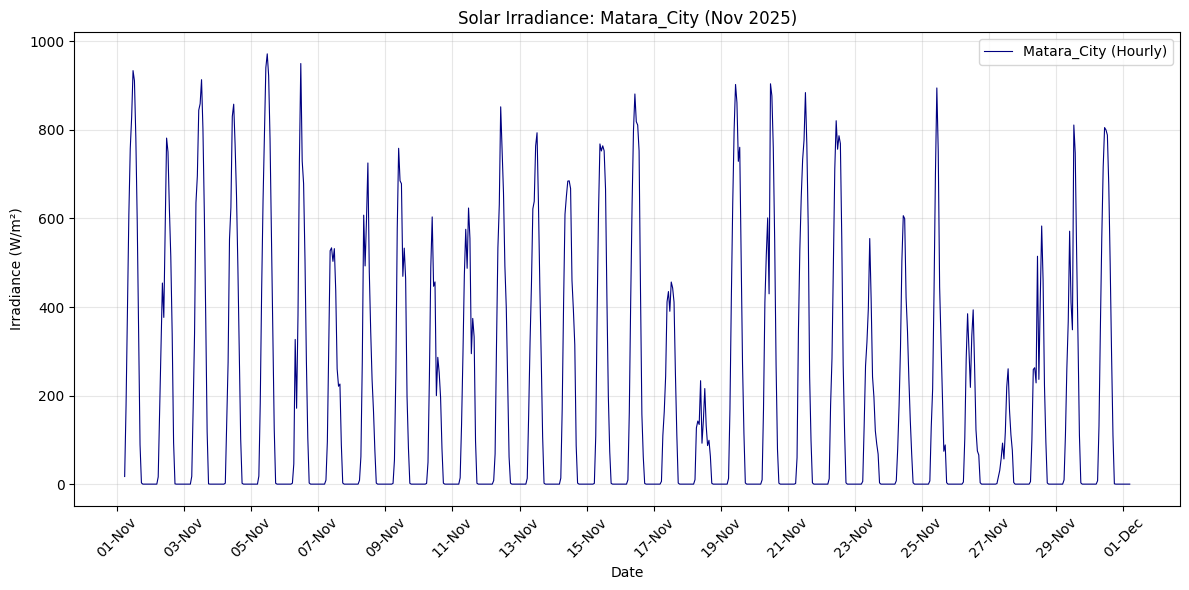

In [ ]:
# @title Batch Process: Nov 1-30, 2025 (Hourly)
import cdsapi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import os

# --- 1. CONFIGURATION ---
URL = 'https://ads.atmosphere.copernicus.eu/api'
KEY = '66951ed0-5cbd-42ce-80ef-0de49597ff7f' # Ensure this is your correct key

client = cdsapi.Client(url=URL, key=KEY)

# --- 2. DEFINE LOCATIONS ---
locations = [
    { "name": "Belihuloya", "lat": 6.7325, "lon": 80.7871 },
    { "name": "Haputale",   "lat": 6.7650, "lon": 80.9510 },
    { "name": "Kandy_City", "lat": 7.2906, "lon": 80.6337 },
    { "name": "Matara_City","lat": 5.9549, "lon": 80.5550 }
]

# --- 3. REQUEST SETTINGS ---
dataset = "cams-solar-radiation-timeseries"
date_range = "2025-11-01/2025-11-30" # Full month
time_step = "1hour"                  # Hourly resolution

# --- 4. LOOP & PROCESS ---
for loc in locations:
    city = loc["name"]
    print(f"\n==========================================")
    print(f"PROCESSING: {city} (Nov 1-30, Hourly)")
    print(f"==========================================")

    # A. Define Request
    request = {
        "variable": "global_horizontal_irradiation",
        "sky_type": "observed_cloud",
        "location": {
            "latitude": loc["lat"],
            "longitude": loc["lon"]
        },
        "altitude": "-999.",
        "date": date_range,
        "time_step": time_step,
        "time_reference": "universal_time",
        "data_format": "csv"
    }

    # Filenames
    raw_file = f"Raw_{city}_Nov2025.csv"
    processed_file = f"{city}_Solar_Nov2025_Hourly.csv"

    try:
        # B. Download
        # Check if already downloaded to save time/quota
        if not os.path.exists(raw_file):
            print(f"-> Downloading data...")
            client.retrieve(dataset, request, raw_file)
            print(f"-> Download complete: {raw_file}")
        else:
            print(f"-> Found existing raw file, skipping download.")

        # C. Process Data
        try:
            df = pd.read_csv(raw_file, sep=';', comment='#', header=None)
        except:
            df = pd.read_csv(raw_file, sep=',', comment='#', header=None)

        # Columns: 0=TimeRange, 6=GHI(Wh/m2)
        # Extract start time from string like "2025-11-01T00:00:00.0/..."
        df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
        df.set_index('Timestamp', inplace=True)

        # UTC -> Sri Lanka Time (+5:30)
        df.index = df.index + pd.Timedelta(hours=5.5)

        # --- UNIT CONVERSION ---
        # For 1-HOUR step: Energy (Wh/m²) = Average Power (W/m²)
        # No multiplication needed.
        df['GHI_W_m2'] = df[6]

        # Save Clean CSV
        df[['GHI_W_m2']].to_csv(processed_file)
        print(f"-> Saved processed CSV: {processed_file}")

        # D. Plot (Full Month)
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['GHI_W_m2'], label=f'{city} (Hourly)', color='navy', linewidth=0.8)

        plt.title(f'Solar Irradiance: {city} (Nov 2025)')
        plt.ylabel('Irradiance (W/m²)')
        plt.xlabel('Date')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Format x-axis to show days clearly
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2)) # Tick every 2 days
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        time.sleep(1) # Polite pause

    except Exception as e:
        print(f"!!! Error processing {city}: {e}")

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. DATA LOADING FUNCTIONS ---

def load_processed_cams(filename):
    """Loads clean CAMS files (Belihuloya, Haputale, Kandy, Matara)"""
    try:
        df = pd.read_csv(filename)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.set_index('Timestamp', inplace=True)
        return df
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def load_raw_gampaha(filename):
    """Loads and cleans the RAW Gampaha CAMS file"""
    try:
        # Read with correct separator (usually ; for raw CAMS)
        try:
            df = pd.read_csv(filename, sep=';', comment='#', header=None)
        except:
            df = pd.read_csv(filename, sep=',', comment='#', header=None)

        # 1. Parse Date (Col 0 is '2025-11-01T00.../...')
        df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
        df.set_index('Timestamp', inplace=True)

        # 2. Convert UTC to Sri Lanka Time (+5:30)
        df.index = df.index + pd.Timedelta(hours=5.5)

        # 3. Get GHI (Col 6). For Hourly data, Wh/m² = W/m². No *60 needed.
        df['GHI_W_m2'] = df[6]

        return df[['GHI_W_m2']]
    except Exception as e:
        print(f"Error loading Gampaha raw file: {e}")
        return None

def load_solcast(filename):
    """Loads Solcast CSV and aligns timezone"""
    try:
        df = pd.read_csv(filename)
        # Parse period_end (e.g., 2025-11-01 06:30:00+05:30)
        df['period_end'] = pd.to_datetime(df['period_end'])
        df.set_index('period_end', inplace=True)

        # Remove Timezone info to match CAMS (Naive Local Time)
        df.index = df.index.tz_localize(None)

        # Rename for clarity
        df.rename(columns={'ghi': 'Solcast_W_m2'}, inplace=True)
        return df[['Solcast_W_m2']]
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

# --- 2. PLOTTING FUNCTION ---

def create_interactive_plot(city_name, df_cams, df_solcast):
    """Creates a Zoomable Plotly Graph"""

    # Merge Data (Inner Join)
    merged = df_cams.join(df_solcast, how='inner')

    if merged.empty:
        print(f"⚠️ No matching dates found for {city_name}")
        return

    # Create Plot
    fig = go.Figure()

    # Add CAMS Line
    fig.add_trace(go.Scatter(
        x=merged.index,
        y=merged['GHI_W_m2'],
        mode='lines',
        name='CAMS (Satellite)',
        line=dict(color='orange', width=2),
        hovertemplate='%{x}<br><b>CAMS:</b> %{y:.1f} W/m²<extra></extra>'
    ))

    # Add Solcast Line
    fig.add_trace(go.Scatter(
        x=merged.index,
        y=merged['Solcast_W_m2'],
        mode='lines',
        name='Solcast (API)',
        line=dict(color='green', width=2, dash='dot'),
        hovertemplate='%{x}<br><b>Solcast:</b> %{y:.1f} W/m²<extra></extra>'
    ))

    # Layout: Zooming, Sliders, and Titles
    fig.update_layout(
        title=f"<b>{city_name}</b>: Solar Irradiance Comparison (Nov 2025)",
        yaxis_title="Irradiance (W/m²)",
        xaxis_title="Time",
        template="plotly_white",
        hovermode="x unified", # Shows both values at cursor line
        xaxis=dict(
            rangeslider=dict(visible=True), # The slider at the bottom
            type="date"
        ),
        legend=dict(
            orientation="h",
            y=1.02, x=1, xanchor="right"
        )
    )

    fig.show()


# --- 3. RUN FOR ALL LOCATIONS ---

# Mapping Files
locations = [
    ("Belihuloya", "Belihuloya_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Belihuloya_Ratnapura_hourly.csv"),
    ("Haputale", "Haputale_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Haputale_Badulla_hourly.csv"),
    ("Kandy City", "Kandy_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Kandy_City_hourly.csv"),
    ("Matara City", "Matara_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Matara_City_hourly.csv"),
    ("Gampaha", "Gampaha_nov_NewADS.csv", "solcast_nov_2025_Gampaha_hourly.csv") # Raw CAMS file
]

for city, cams_file, sol_file in locations:
    print(f"Processing {city}...")

    # Load Data
    if city == "Gampaha":
        df_c = load_raw_gampaha(cams_file)
    else:
        df_c = load_processed_cams(cams_file)

    df_s = load_solcast(sol_file)

    # Generate Plot
    if df_c is not None and df_s is not None:
        create_interactive_plot(city, df_c, df_s)

Processing Belihuloya...


Processing Haputale...


Processing Kandy City...


Processing Matara City...


Processing Gampaha...


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# --- 1. DATA LOADING FUNCTIONS ---

def load_cams_data(filename, is_raw=False):
    """
    Loads CAMS data.
    - If is_raw=True (Gampaha), processes UTC -> Local Start Time.
    - If is_raw=False (Others), loads existing Local Start Time.
    """
    try:
        if is_raw:
            # Load Raw (Semicolon delimiter, metadata rows)
            try:
                df = pd.read_csv(filename, sep=';', comment='#', header=None)
            except:
                df = pd.read_csv(filename, sep=',', comment='#', header=None)

            # Parse Timestamp (UTC Start of Hour)
            df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
            df.set_index('Timestamp', inplace=True)

            # Convert UTC to Sri Lanka Local Time (+5:30)
            df.index = df.index + pd.Timedelta(hours=5.5)

            # Col 6 is GHI (Wh/m2). For hourly, Wh/m2 = W/m2 avg.
            df['GHI_W_m2'] = df[6]
            return df[['GHI_W_m2']]

        else:
            # Load Processed (Comma delimiter, already Local Start Time)
            df = pd.read_csv(filename)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df.set_index('Timestamp', inplace=True)
            return df[['GHI_W_m2']]

    except Exception as e:
        print(f"Error loading CAMS {filename}: {e}")
        return None

def load_solcast_data(filename):
    """
    Loads Solcast data.
    - Converts 'period_end' to 'period_start' (Subtract 1 Hour).
    - Ensures Timezone naive to match CAMS.
    """
    try:
        df = pd.read_csv(filename)

        # Parse period_end (e.g., 2025-11-01 06:30:00+05:30)
        df['period_end'] = pd.to_datetime(df['period_end'])

        # KEY FIX: Solcast gives "Period End". CAMS gives "Period Start".
        # We must shift Solcast BACK by 1 hour to align "Start-to-Start".
        # (Assuming period is PT1H, which is standard for these files)
        df['period_start'] = df['period_end'] - pd.Timedelta(hours=1)

        df.set_index('period_start', inplace=True)

        # Remove Timezone info (make naive) to match CAMS
        df.index = df.index.tz_localize(None)

        df.rename(columns={'ghi': 'Solcast_W_m2'}, inplace=True)
        return df[['Solcast_W_m2']]

    except Exception as e:
        print(f"Error loading Solcast {filename}: {e}")
        return None

# --- 2. PLOTTING FUNCTION ---

def create_aligned_plot(city_name, df_cams, df_solcast):
    """Creates a Zoomable Plotly Graph with aligned data"""

    # Merge Data (Inner Join ensures we only see overlapping, aligned times)
    merged = df_cams.join(df_solcast, how='inner')

    if merged.empty:
        print(f"⚠️ No overlapping data found for {city_name} after alignment!")
        return

    # Create Plot
    fig = go.Figure()

    # CAMS Line
    fig.add_trace(go.Scatter(
        x=merged.index,
        y=merged['GHI_W_m2'],
        mode='lines',
        name='CAMS (Satellite)',
        line=dict(color='orange', width=2),
        hovertemplate='%{x}<br><b>CAMS:</b> %{y:.1f} W/m²<extra></extra>'
    ))

    # Solcast Line
    fig.add_trace(go.Scatter(
        x=merged.index,
        y=merged['Solcast_W_m2'],
        mode='lines',
        name='Solcast (API)',
        line=dict(color='green', width=2, dash='dot'),
        hovertemplate='%{x}<br><b>Solcast:</b> %{y:.1f} W/m²<extra></extra>'
    ))

    # Layout
    fig.update_layout(
        title=f"<b>{city_name}</b>: Solar Irradiance (Aligned)<br><sub>Solcast shifted -1h to match CAMS Start-Time</sub>",
        yaxis_title="Irradiance (W/m²)",
        xaxis_title="Time (Local)",
        template="plotly_white",
        hovermode="x unified",
        xaxis=dict(
            rangeslider=dict(visible=True),
            type="date"
        ),
        legend=dict(
            orientation="h",
            y=1.02, x=1, xanchor="right"
        )
    )

    fig.show()

# --- 3. EXECUTION ---

# Define File Pairs
locations = [
    # (City Name, CAMS File, Solcast File, Is_CAMS_Raw?)
    ("Belihuloya", "Belihuloya_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Belihuloya_Ratnapura_hourly.csv", False),
    ("Haputale", "Haputale_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Haputale_Badulla_hourly.csv", False),
    ("Kandy City", "Kandy_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Kandy_City_hourly.csv", False),
    ("Matara City", "Matara_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Matara_City_hourly.csv", False),
    ("Gampaha", "Gampaha_nov_NewADS.csv", "solcast_nov_2025_Gampaha_hourly.csv", True) # Raw CAMS
]

for city, cams_file, sol_file, is_raw in locations:
    print(f"Aligning and Plotting {city}...")

    df_c = load_cams_data(cams_file, is_raw)
    df_s = load_solcast_data(sol_file)

    if df_c is not None and df_s is not None:
        create_aligned_plot(city, df_c, df_s)

Aligning and Plotting Belihuloya...


Aligning and Plotting Haputale...


Aligning and Plotting Kandy City...


Aligning and Plotting Matara City...


Aligning and Plotting Gampaha...


In [ ]:
import pandas as pd
import plotly.graph_objects as go

# --- 1. DATA LOADING & PROCESSING FUNCTIONS ---

def get_daily_average_cams(filename, is_raw=False):
    """
    Loads CAMS data, aligns time, and calculates Daily Average (Mean W/m²).
    """
    try:
        if is_raw:
            # Load Raw (Semicolon delimiter, metadata rows)
            try:
                df = pd.read_csv(filename, sep=';', comment='#', header=None)
            except:
                df = pd.read_csv(filename, sep=',', comment='#', header=None)

            # Parse Timestamp (UTC Start of Hour)
            df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
            df.set_index('Timestamp', inplace=True)

            # Convert UTC to Sri Lanka Local Time (+5:30)
            df.index = df.index + pd.Timedelta(hours=5.5)

            # Col 6 is GHI (Wh/m2). For hourly, Wh/m2 = W/m2 avg power.
            df['GHI_W_m2'] = df[6]

        else:
            # Load Processed (Comma delimiter, already Local Start Time)
            df = pd.read_csv(filename)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df.set_index('Timestamp', inplace=True)
            # Ensure column name is consistent
            if 'GHI_W_m2' not in df.columns and 'GHI' in df.columns:
                 df['GHI_W_m2'] = df['GHI'] # Handle potential naming variations

        # Resample to Daily Average (Mean of 24h)
        daily_df = df[['GHI_W_m2']].resample('D').mean()
        return daily_df

    except Exception as e:
        print(f"Error loading CAMS {filename}: {e}")
        return None

def get_daily_average_solcast(filename):
    """
    Loads Solcast data, aligns time (-1h shift), and calculates Daily Average.
    """
    try:
        df = pd.read_csv(filename)

        # Parse period_end
        df['period_end'] = pd.to_datetime(df['period_end'])

        # Shift back 1 hour to align to Period Start
        df['period_start'] = df['period_end'] - pd.Timedelta(hours=1)
        df.set_index('period_start', inplace=True)

        # Remove Timezone info
        df.index = df.index.tz_localize(None)

        df.rename(columns={'ghi': 'Solcast_W_m2'}, inplace=True)

        # Resample to Daily Average
        daily_df = df[['Solcast_W_m2']].resample('D').mean()
        return daily_df

    except Exception as e:
        print(f"Error loading Solcast {filename}: {e}")
        return None

# --- 2. PLOTTING FUNCTION ---

def create_daily_plot(city_name, daily_cams, daily_solcast):
    """Creates a Bar plot for Daily Averages"""

    merged = daily_cams.join(daily_solcast, how='inner')

    if merged.empty:
        print(f"⚠️ No overlapping data for {city_name}")
        return

    # Print first few rows to the output for review
    print(f"\n--- {city_name} Daily Averages (W/m²) ---")
    print(merged.round(2).head())
    print("...")

    fig = go.Figure()

    # CAMS Bar
    fig.add_trace(go.Bar(
        x=merged.index,
        y=merged['GHI_W_m2'],
        name='CAMS (Daily Avg)',
        marker_color='orange',
        opacity=0.7,
        hovertemplate='%{x}<br>CAMS: %{y:.1f} W/m²<extra></extra>'
    ))

    # Solcast Bar
    fig.add_trace(go.Bar(
        x=merged.index,
        y=merged['Solcast_W_m2'],
        name='Solcast (Daily Avg)',
        marker_color='green',
        opacity=0.7,
        hovertemplate='%{x}<br>Solcast: %{y:.1f} W/m²<extra></extra>'
    ))

    fig.update_layout(
        title=f"<b>{city_name}</b>: Daily Average Irradiance (Nov 2025)",
        yaxis_title="Average Irradiance (W/m²)",
        xaxis_title="Date",
        barmode='group', # Side by side bars
        template="plotly_white",
        hovermode="x unified"
    )

    fig.show()

# --- 3. MAIN EXECUTION ---

locations = [
    ("Belihuloya", "Belihuloya_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Belihuloya_Ratnapura_hourly.csv", False),
    ("Haputale", "Haputale_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Haputale_Badulla_hourly.csv", False),
    ("Kandy City", "Kandy_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Kandy_City_hourly.csv", False),
    ("Matara City", "Matara_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Matara_City_hourly.csv", False),
    ("Gampaha", "Gampaha_nov_NewADS.csv", "solcast_nov_2025_Gampaha_hourly.csv", True)
]

for city, cams_file, sol_file, is_raw in locations:
    df_c = get_daily_average_cams(cams_file, is_raw)
    df_s = get_daily_average_solcast(sol_file)

    if df_c is not None and df_s is not None:
        create_daily_plot(city, df_c, df_s)


--- Belihuloya Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    213.04        198.42
2025-11-02    173.15        139.83
2025-11-03    249.59        224.25
2025-11-04    242.41        230.08
2025-11-05    228.43        231.46
...



--- Haputale Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    211.25        215.21
2025-11-02    167.22        154.00
2025-11-03    217.13        215.50
2025-11-04    241.16        206.25
2025-11-05    225.22        229.67
...



--- Kandy City Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    306.91        280.16
2025-11-02    228.19        224.96
2025-11-03    288.81        276.54
2025-11-04    276.17        235.79
2025-11-05    227.32        211.42
...



--- Matara City Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    338.85        338.16
2025-11-02    208.22        246.33
2025-11-03    266.04        263.62
2025-11-04    233.31        235.12
2025-11-05    280.50        266.62
...



--- Gampaha Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    338.95        323.84
2025-11-02    193.86        224.00
2025-11-03    235.22        228.96
2025-11-04    208.30        198.12
2025-11-05    177.20        174.83
...


In [2]:
import pandas as pd
import plotly.graph_objects as go

# ==========================================
# 1. DATA PROCESSING FUNCTIONS
# ==========================================

def get_daily_average_cams(filename, is_raw=False):
    """
    Loads CAMS data, aligns time, and calculates Daily Average (Mean W/m²).
    Handles both 'Raw' (semicolon) and 'Processed' (comma) formats.
    """
    try:
        if is_raw:
            # --- Load Raw CAMS File (e.g. Gampaha) ---
            # Try semicolon separator first (standard for raw CAMS)
            try:
                df = pd.read_csv(filename, sep=';', comment='#', header=None)
            except:
                df = pd.read_csv(filename, sep=',', comment='#', header=None)

            # Parse Timestamp (Column 0 is like '2025-11-01T00:00...')
            df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
            df.set_index('Timestamp', inplace=True)

            # Convert UTC to Sri Lanka Local Time (+5:30)
            df.index = df.index + pd.Timedelta(hours=5.5)

            # Column 6 is GHI (Wh/m²). For hourly data, Wh/m² = Avg W/m²
            df['GHI_W_m2'] = df[6]

        else:
            # --- Load Processed CAMS File ---
            df = pd.read_csv(filename)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df.set_index('Timestamp', inplace=True)

            # Ensure column name is consistent (handle variations)
            if 'GHI_W_m2' not in df.columns and 'GHI' in df.columns:
                 df['GHI_W_m2'] = df['GHI']

        # Calculate Daily Average (Mean of 24h)
        daily_df = df[['GHI_W_m2']].resample('D').mean()
        return daily_df

    except Exception as e:
        print(f"Error loading CAMS {filename}: {e}")
        return None

def get_daily_average_solcast(filename):
    """
    Loads Solcast data, shifts time back by 1 hour to align, and calculates Daily Average.
    """
    try:
        df = pd.read_csv(filename)

        # Parse period_end (e.g. 2025-11-01 06:30)
        df['period_end'] = pd.to_datetime(df['period_end'])

        # Shift back 1 hour to get 'Period Start' matching CAMS
        df['period_start'] = df['period_end'] - pd.Timedelta(hours=1)
        df.set_index('period_start', inplace=True)

        # Remove Timezone info to match CAMS
        df.index = df.index.tz_localize(None)

        df.rename(columns={'ghi': 'Solcast_W_m2'}, inplace=True)

        # Calculate Daily Average
        daily_df = df[['Solcast_W_m2']].resample('D').mean()
        return daily_df

    except Exception as e:
        print(f"Error loading Solcast {filename}: {e}")
        return None

# ==========================================
# 2. PLOTTING FUNCTION (SCATTER DIAGRAM)
# ==========================================

def create_daily_scatter_plot(city_name, daily_cams, daily_solcast):
    """Creates an interactive Scatter Plot for Daily Averages"""

    # Merge on date index
    merged = daily_cams.join(daily_solcast, how='inner')

    if merged.empty:
        print(f"⚠️ No overlapping data for {city_name}")
        return

    # Print Table to Output
    print(f"\n--- {city_name} Daily Averages (W/m²) ---")
    print(merged.round(2).head())
    print("...")

    fig = go.Figure()

    # CAMS Scatter Points (Orange Circles)
    fig.add_trace(go.Scatter(
        x=merged.index,
        y=merged['GHI_W_m2'],
        mode='markers+lines',
        name='CAMS (Daily Avg)',
        marker=dict(color='orange', size=8, symbol='circle'),
        line=dict(width=1, dash='dot'),
        hovertemplate='%{x}<br>CAMS: %{y:.1f} W/m²<extra></extra>'
    ))

    # Solcast Scatter Points (Green Triangles)
    fig.add_trace(go.Scatter(
        x=merged.index,
        y=merged['Solcast_W_m2'],
        mode='markers+lines',
        name='Solcast (Daily Avg)',
        marker=dict(color='green', size=9, symbol='triangle-up'),
        line=dict(width=1, dash='dot'),
        hovertemplate='%{x}<br>Solcast: %{y:.1f} W/m²<extra></extra>'
    ))

    # Layout Configuration
    fig.update_layout(
        title=f"<b>{city_name}</b>: Daily Average Irradiance (Scatter Plot)",
        yaxis_title="Average Irradiance (W/m²)",
        xaxis_title="Date",
        template="plotly_white",
        hovermode="x unified",
        xaxis=dict(
            tickmode='linear',
            dtick="D1",        # Label every 1 day
            tickformat="%b %d"
        )
    )

    fig.show()

# ==========================================
# 3. MAIN EXECUTION LOOP
# ==========================================

# List of locations: (City Name, CAMS Filename, Solcast Filename, Is Raw CAMS?)
locations = [
    ("Belihuloya", "Belihuloya_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Belihuloya_Ratnapura_hourly.csv", False),
    ("Haputale", "Haputale_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Haputale_Badulla_hourly.csv", False),
    ("Kandy City", "Kandy_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Kandy_City_hourly.csv", False),
    ("Matara City", "Matara_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Matara_City_hourly.csv", False),
    ("Gampaha", "Gampaha_nov_NewADS.csv", "solcast_nov_2025_Gampaha_hourly.csv", True)
]

# Run the process for each city
for city, cams_file, sol_file, is_raw in locations:
    df_c = get_daily_average_cams(cams_file, is_raw)
    df_s = get_daily_average_solcast(sol_file)

    if df_c is not None and df_s is not None:
        create_daily_scatter_plot(city, df_c, df_s)


--- Belihuloya Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    213.04        198.42
2025-11-02    173.15        139.83
2025-11-03    249.59        224.25
2025-11-04    242.41        230.08
2025-11-05    228.43        231.46
...



--- Haputale Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    211.25        215.21
2025-11-02    167.22        154.00
2025-11-03    217.13        215.50
2025-11-04    241.16        206.25
2025-11-05    225.22        229.67
...



--- Kandy City Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    306.91        280.16
2025-11-02    228.19        224.96
2025-11-03    288.81        276.54
2025-11-04    276.17        235.79
2025-11-05    227.32        211.42
...



--- Matara City Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    338.85        338.16
2025-11-02    208.22        246.33
2025-11-03    266.04        263.62
2025-11-04    233.31        235.12
2025-11-05    280.50        266.62
...



--- Gampaha Daily Averages (W/m²) ---
            GHI_W_m2  Solcast_W_m2
Timestamp                         
2025-11-01    338.95        323.84
2025-11-02    193.86        224.00
2025-11-03    235.22        228.96
2025-11-04    208.30        198.12
2025-11-05    177.20        174.83
...


In [4]:
import pandas as pd
import plotly.graph_objects as go

# --- 1. CALCULATION FUNCTIONS ---

def calculate_monthly_average_cams(filename, is_raw=False):
    """Calculates the mean irradiance over the entire month for CAMS."""
    try:
        if is_raw:
            # Load Raw (Gampaha)
            try:
                df = pd.read_csv(filename, sep=';', comment='#', header=None)
            except:
                df = pd.read_csv(filename, sep=',', comment='#', header=None)
            df['Timestamp'] = pd.to_datetime(df[0].str.split('/').str[0])
            df.set_index('Timestamp', inplace=True)
            df.index = df.index + pd.Timedelta(hours=5.5)
            df['GHI_W_m2'] = df[6]
        else:
            # Load Processed
            df = pd.read_csv(filename)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df.set_index('Timestamp', inplace=True)
            if 'GHI_W_m2' not in df.columns: df['GHI_W_m2'] = df['GHI']

        # Daily Mean -> Monthly Mean
        return df[['GHI_W_m2']].resample('D').mean().mean().iloc[0]
    except: return None

def calculate_monthly_average_solcast(filename):
    """Calculates the mean irradiance over the entire month for Solcast."""
    try:
        df = pd.read_csv(filename)
        df['period_end'] = pd.to_datetime(df['period_end'])
        df['period_start'] = df['period_end'] - pd.Timedelta(hours=1)
        df.set_index('period_start', inplace=True)
        df.index = df.index.tz_localize(None)
        df.rename(columns={'ghi': 'Solcast_W_m2'}, inplace=True)

        # Daily Mean -> Monthly Mean
        return df[['Solcast_W_m2']].resample('D').mean().mean().iloc[0]
    except: return None

# --- 2. MAIN EXECUTION ---

locations = [
    ("Belihuloya", "Belihuloya_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Belihuloya_Ratnapura_hourly.csv", False),
    ("Haputale", "Haputale_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Haputale_Badulla_hourly.csv", False),
    ("Kandy City", "Kandy_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Kandy_City_hourly.csv", False),
    ("Matara City", "Matara_City_Solar_Nov2025_Hourly.csv", "solcast_nov_2025_Matara_City_hourly.csv", False),
    ("Gampaha", "Gampaha_nov_NewADS.csv", "solcast_nov_2025_Gampaha_hourly.csv", True)
]

results = []
for city, cams_file, sol_file, is_raw in locations:
    cams_avg = calculate_monthly_average_cams(cams_file, is_raw)
    sol_avg = calculate_monthly_average_solcast(sol_file)
    if cams_avg is not None and sol_avg is not None:
        results.append({"Location": city, "CAMS": cams_avg, "Solcast": sol_avg})

df_results = pd.DataFrame(results)

# --- 3. PLOT ---
fig = go.Figure()

# CAMS Bar
fig.add_trace(go.Bar(
    x=df_results['Location'], y=df_results['CAMS'],
    name='CAMS (Monthly Avg)', marker_color='orange',
    text=df_results['CAMS'].round(1), textposition='auto'
))

# Solcast Bar
fig.add_trace(go.Bar(
    x=df_results['Location'], y=df_results['Solcast'],
    name='Solcast (Monthly Avg)', marker_color='green',
    text=df_results['Solcast'].round(1), textposition='auto'
))

fig.update_layout(
    title='<b>Monthly Average Solar Irradiance (Nov 2025)</b>',
    yaxis_title='Avg Irradiance (W/m²)',
    barmode='group',
    template='plotly_white'
)

fig.show()